# <center>MO444 - Aprendizado de Máquina e Reconhecimento de Padrões</center>
## <center>Primeiro semestre de 2021</center>
## <center>Projeto 3: Algoritmos Evolucionários e Aprendizado por Reforço</center>
## <center>Discentes: Elisa Dell'Arriva (135551) e Felipe de Carvalho Pereira (230214)</center>
_________________________________________________________________________

# 1 Introdução

O presente *notebook* consiste no terceiro projeto avaliativo da disciplina MO444 - Aprendizado de Máquina e Reconhecimento de Padrões, ministrada pela Profa. Dra. Esther Colombini. O principal objetivo da atividade foi o de implementar e experimentar técnicas de Algoritmos Evolucionários e de Aprendizado por Reforço para resolver o Problema do Pacman.<br>

Na primeira parte do projeto, descrita na Seção 2, buscamos resolver o Problema do Pacman por meio de um algoritmo de Programação Genética baseado nos métodos empregados em [4] e [5]. Na segunda etapa, descrita na Seção 3, lidamos com o mesmo problema, mas empregamos uma técnica de Aprendizado por Reforço denoniminada Q-learning, de maneira semelhante ao que é apresentado em [6]. Na Seção 4, comparamos os resultados obtidos pelas diferentes abordagens.

## 1.1 O Problema do Pacman

O famoso jogo do Pacman se passa em um labirinto, na forma de um tabuleiro, em que o Pacman, o agente controlado pelo usuário, movimenta-se por meio de células (ou casas). O objetivo do jogo é coletar todos os itens de comida dispostos no labirinto. Além do Pacman, existem outros agentes que se movimentam pelo labirinto. Estes são denominados fantasmas e não são controlados pelo usuário. O jogo acaba somente em duas ocasiões: quando todos os itens de comida forem consumidos e, neste caso, decreta-se vitória; ou quando o Pacman colide com algum fantasma, e neste caso, decreta-se derrota.

Além dos itens de comida, existem cápsulas que também são consumíveis pelo Pacman. No momento em que uma cápsula é consumida, a velocidade com a qual os fantasmas se movimentam é reduzida, e os mesmos tornam-se comestíveis pelo Pacman. Contudo, tais efeitos persistem por um curto intervalo de tempo. Quando um fantasma está sob o efeito da cápsula, dizemos que ele está *comestível*, caso contrário dizemos que ele está *ativo*. A pontuação do usuário durante o jogo é baseada nas seguintes regras:

* A pontuação no início do jogo é igual a 0;
* A cada iteração do jogo, a pontuação é decrementada em uma unidade;
* Quando um item de comida é consumido, a pontuação é incrementada em 10 unidades;
* Quando um fantasma comestível é consumido, a pontuação é incrementada em 200 unidades;
* Quando o Pacman colide com um fantasma ativo a pontuação é decrementada em 500 unidades;
* Quando o Pacman consome o último item de comida, a pontuação é incrementada em 500 unidades.

Nesse contexto, o Problema do Pacman corresponde em desenvolver um agente capaz de controlar o Pacman com o objetivo de vencer o jogo e maximizar a pontuação obtida.

Junto à especificação deste projeto, foi fornecida uma API que implementa o jogo do Pacman na linguagem Python 2. Contudo, uma versão em Python 3 desta mesma API está disponível em [7] e esta última foi aquela empregada neste trabalho. Em particular, os mapas (ou *layouts*) utilizados foram: smallClassic, mediumClassic e originalClassic.

# 2 Parte $I$ - Modelo Evolucionário

Nesta Seção, descrevemos a abordagem baseada em modelos evolucionários utilizada neste trabalho para resolver o Problema do Pacman.

## 2.1 Algoritmo Genético

Algoritmos genéticos são abordagens heurísticas nas quais modelam-se soluções de um determinado problema como indivíduos de uma população. Em cada iteração do algoritmo, tem-se uma geração (no sentido temporal) da população. Ao longo das gerações, os indivíduos se reproduzem e sofrem mutações, de modo análogo ao que é observado na natureza com diversas espécies. Em particular, o algoritmo aplica um procedimento semelhante ao processo de Seleção Natural, de tal modo que apenas os indivíduos mais adaptados sobrevivem através das gerações.

A maneira como soluções são representadas por indivíduos varia de acordo com o problema tratado. Além disso, a literatura (vide [1,2,3]) apresenta diversas maneiras de se implementar as etapas de reprodução (*crossover*), mutação e substituição de população. Em linhas gerais, um algoritmo genético funciona da seguinte maneira.

* 1 - Uma população inicial de indivíduos (possivelmente produzidos de maneira aleatorizada) é estabelecida;
* 2 - Pares de indivíduos (ou pais) são selecionados para reprodução e novos indivíduos (filhos) são produzidos, os quais herdam características de ambos os pais;
* 3 - Uma fração da população é escolhida para sofrer mutações, isto é, alterações randomizadas em sua estrutura;
* 4 - Cada indivíduo é avaliado de acordo com uma fução de aptidão (ou *fitness*);
* 5 - Os indivíduos considerados mais aptos são escolhidos para compor a próxima geração da população;
* 6 - Repete-se os passos 2 a 5 até que a população convirja ou que o limite de iterações preestabelecido seja atingido.

## 2.2 Programação Genética

Neste trabalho, escolhemos a técnica denominada Programação Genética para resolver o Problema do Pacman. A Progração Genética pode ser entendida como uma variação dos algoritmos genéticos em que cada indivíduo da população corresponde a um programa (*software*) ao invés de uma solução propriamente dita. Quando executado, o programa (indivíduo) deve ser capaz de produzir uma solução para o problema.

No contexto do jogo do Pacman, um indivíduo consiste em uma árvore de decisão por meio da qual chega-se a uma escolha de movimentação do Pacman, considerando o estado corrente do jogo. Denominaremos esse tipo de árvore de decisão como *política*, i.e., uma política de movimentação do Pacman. Para cada iteração do jogo tem-se as informações a respeito da disposição dos itens e agentes no labirinto. Assim, quando uma política é executada, a mesma se utiliza das informações do labirinto para decidir o próximo movimento do Pacman (norte, sul, leste, oeste ou ficar parado). 

A seguir, descrevemos a modelagem de Programação Genética que empregamos para resolver o Problema do Pacman, a qual foi baseada nos algoritmos desenvolvidos em [4,5].

### 2.2.1 Modelagem do indivíduo

Cada indivíduo da população corresponde a uma política e é implementado por meio de uma árvore. Cada nó da árvore tem uma única natureza entre as que são descritas abaixo:

* Data: valor numérico que pode ser uma constante ou uma informação acerca do atual estado do tabuleiro;
* Action: representa o objetivo que baseará a próxima ação do Pacman;
* Iflte: (*If less then else*): nó que possui quatro filhos, sendo os dois primeiros da natureza Data e os últimos da natureza Action ou Iflte.

Se um nó é do tipo Data, então ele tem alguma das seguintes subnaturezas:

* DistToFood: a menor das distâncias de Manhattan entre a posição do Pacman e as posições dos itens de comida restantes;
* DistToCapsule: a menor das distâncias de Manhattan entre a posição do Pacman e as posições das cápsulas restantes;
* DistToActiveGhost: a menor das distâncias de Manhattan entre a posição do Pacman e as posições dos fantasmas ativos;
* DistToEdibleGhost: a menor das distâncias de Manhattan entre a posição do Pacman e as posições dos fantasmas comestíveis;
* Constant: um valor constante entre 1 e o *maxConst*, onde *maxConst* é um parâmetro.

Se um nó é do tipo Action, então ele tem alguma das seguintes subnaturezas:

* GetFood: Pacman deve se movimentar em direção ao item de comida mais próximo;
* GetCapsule: Pacman deve se movimentar em direção à capsula mais próxima;
* EscapeFromGhost: Pacman deve se movimentar na direção que o deixa mais distintante do fantasma mais próximo;
* GetEdibleGhost: Pacman deve se movimentar em direção ao fantasma comestível mais próximo.

Apenas nós do tipo Iflte possuem filhos e, em particular, a raiz da árvore de decisão é sempre do tipo Iflte.

### 2.2.2 *Parsing* do indivíduo

Por meio da API do Pacman, criamos uma classe de agente que implementa (sobrescreve) a função *getAction*. A função *getAction* recebe o objeto *state* e deve retornar a ação que o Pacman irá realizar, i.e., ir para a posição adjacente ao norte, sul, leste ou oeste ou ainda permanecer na posição atual. O objeto *state* é útil para coletar informações acerca do atual estado do labirinto. Observe que durante uma partida, a função *getAction* é invocada a cada iteração do jogo.

Em nossa modelagem, a função *getAction* invoca uma função de *parsing* que recebe o objeto *state* e uma política. Na função de *parsing*, a árvore de decisão (política) é percorrida a partir da raiz até algum nó folha que é uma ação. A ação determina um movimento do Pacman que é retornado pelo *parser* e, em seguida retornado pela função *getAction*. A seguir, detalharemos a função de *parsing*. 

Primeiramente, visitamos o nó raiz da política. Como já mencionamos, trata-se de um nó do tipo Iflte. Para esse tipo, faz-se o que segue. Primeiro avaliamos o valor numérico dos dois primeiros filhos do nó raiz, os quais são do tipo Data. Se o valor do primeiro filho for menor que o do segundo, então o terceiro filho do nó raiz é o próximo a ser visitado, caso contrário, o quarto filho é o próximo a ser visitado. Como vimos, esses dois últimos só podem ser do tipo Action ou Iflte. Se o próximo nó for do tipo Iflte, repete-se o procedimento descrito anteriormente. Caso contrário, se for do tipo Action, então é executado um procedimento que determina a ação do Pacman e o *parsing* é encerrado.

Quando o valor de um nó do tipo Data é avaliado, faz-se o que segue de acordo com a subnatureza do nó. Se a subnatureza é Constant, então já existe um valor numérico constante associado àquele nó, o qual é retornado. Caso contrário, trata-se de uma subnatureza que é a distância do Pacman para objetos de um mesmo tipo: comida, cápsula, fantasma ativo ou comestível. Nesse caso, calcula-se a distância (de Manhattan) entre o Pacman e todos os objetos daquele tipo e retorna-se a menor das distâncias. Por exemplo, se a subnatureza é DistToFood, então é retornada a distância (de Manhattan) entre a posição do Pacman e a posição do item de comida mais próximo (considerando a distância de Manhattan).

Quando um nó do tipo Ação é visitado, faz-se o que segue de acordo com a subnatureza do nó. Se a subnatureza é EscapeFromGhost, então calculamos a distância (de Manhattan) entre a posição do Pacman e o fantasma ativo mais próximo (considerando a distância de Manhattan). Em seguida, escolhemos a movimentação do Pacman que aumenta ou mantém a distância em relação àquele fantasma. Na prática isso significa fugir daquele fantasma com uma escolha gulosa de movimentação. Se a subnatureza é diferente de EscapeFromGhost, trata-se de uma subnatureza em que o Pacman objetivará comer algum item: comida, cápsula ou fantasma comestível. Nesse caso, calcula-se o caminho mais curto no labirinto entre o Pacman e o item mais próximo. O movimento do Pacman será aquele que vai em direção ao item nesse caminho. Para calcular esses caminhos, implementamos uma estrutura de dados adicional em que as células acessíveis do labirinto são vértices de um grafo e, dessa forma, a menor caminho entre duas células é calculado por uma busca em largura naquele grafo. Observe que sempre que um menor caminho entre duas células é calculado, o armazenamos em memória para que não seja necessário recalculá-lo, caso o cenário venha a se repetir. No cenário especial em que não restam itens do tipo pelo qual ação objetiva alcançar, a ação padrão tomada é GetFood.

### 2.2.3 Operações genéticas

Adiante, descrevemos as operações relativas a evolução da população, tais como *crossover*, mutação e substituição, que são adotadas no nosso modelo. A população inicial é produzida com indivíduos gerados de maneira aleatorizada com profundidade da árvore de decisão limitada a um parâmetro preestabelecido. Além disso, o tamanho $n$ da população também é parametrizado, porém é fixo para todas as iterações do algoritmo.

Seja $P$ o conjunto de $n$ indivíduos da $i$-ésima geração. O primeiro passo é fazer com que os indivíduos se reproduzam. Para isso, selecionamos dois indivíduos $p_1$ e $p_2$ de $P$ de maneira puramente aleatória. Em seguida, criamos uma cópia $f_1$ de $p_1$ e uma cópia $f_2$ de $p_2$. Depois, elencamos uma lista de nós do tipo Iflte (excetuando o nó raiz) de $f_1$ e fazemos o mesmo para $f_2$. Mais à frente, sorteamos de tais listas (de maneira puramente aleatória) um nó Iflte de $f_1$ e um nó Iflte de $f_2$ e trocamos, entre $f_1$ e $f_2$, as subárvores enraizadas nesses nós. Por fim acrescentamos $f_1$ e $f_2$ a população $P$. Repetimos esse procedimento até que o total de filhos gerados atinja um valor parametrizado.

Em seguida, aplicamos o processo de mutação. Para isso, selecionamos um subconjunto $X$ de $P$ e para cada indivíduo $x \in X$, criamos uma cópia $x'$ de $x$ e alteramos $x'$ da seguinte maneira. Elencamos uma lista de nós de $x'$ que não são do tipo Iflte e sorteamos um deles. Se o nó for do tipo Action, alteramos a subnatureza do nó para uma subnatureza diferente e de maneira aleatorizada. Se o nó for do tipo Data, temos dois casos. Se a subnatureza for Constant, então alteramos aleatoriamente o valor da constante associada ao nó. Caso contrário, alteramos a subnatureza do nó para alguma que é diferente da atual e diferente de Constant. Em seguida adicionamos $x'$ a $P$.

O penúltimo passo é avaliar o *fitness* de cada indivíduo de $P$. No nosso modelo, o *fitness* de um indivíduo é igual à média das pontuações de 10 execuções do jogo com sementes (de geração de número pseudoaleatório) distintas.

Por fim, os $n$ indivíduos de $P$ com maior *fitness* são escolhidos para constituir a $(i+1)$-ésima geração.

## 2.3 Código-fonte

A seguir, temos o código-fonte relativo à Parte $I$ do projeto.

In [1]:
# Importação de módulos.
from pacman import *
import numpy as np
import random
import math
from game import Directions
from game import Agent
import copy
import math
import matplotlib.pyplot as plt

# Semente para geração de números pseudoaleatórios.
seed = 6814984
random.seed(seed)

###############################################################################
# Implementações relativas à obtenção de caminhos entre células do tabuleiro. #
###############################################################################

# Classe que representa uma célula do labirinto.
class Cell:
    coordinates = None
    adjacency = np.array([])
    visited = False
    parent = None

# Função que retorna uma lista de células do grafo que representa o labirinto
# e dicionário que mapeia as coordenadas das células nos objetos do tipo Cell.
def get_list_and_dict_of_cells(layout):
    dict_of_cells = dict([])
    list_of_cells = np.array([])

    for x in range(layout.width):
        for y in range(layout.height):
            if not layout.walls[x][y]:
                new_cell = Cell()
                new_cell.coordinates = (x,y)
                dict_of_cells[str(x) + ',' + str(y)] = new_cell
                list_of_cells = np.append(list_of_cells, new_cell)

    for cell in list_of_cells:
        x = cell.coordinates[0]
        y = cell.coordinates[1]

        if x - 1 >= 0 and not layout.walls[x-1][y]:
            cell.adjacency = np.append(cell.adjacency, dict_of_cells[str(x-1) + ',' + str(y)])

        if y - 1 >= 0 and not layout.walls[x][y-1]:
            cell.adjacency = np.append(cell.adjacency, dict_of_cells[str(x) + ',' + str(y-1)])

        if x + 1 <= layout.width and not layout.walls[x+1][y]:
            cell.adjacency = np.append(cell.adjacency, dict_of_cells[str(x+1) + ',' + str(y)])

        if y + 1 <= layout.height and not layout.walls[x][y+1]:
            cell.adjacency = np.append(cell.adjacency, dict_of_cells[str(x) + ',' + str(y+1)])
    
    return list_of_cells, dict_of_cells
    
# Função que executa uma busca em profundidade no grafo que representa o labirinto
# e determina o menor caminho no labirinto entre duas células.
def find_shortest_path(initial_cell_coordinates, final_cell_coordinates, list_of_cells, dict_of_cells):
    
    initial_cell = dict_of_cells[str(initial_cell_coordinates[0]) + ',' + str(initial_cell_coordinates[1])]
    final_cell = dict_of_cells[str(final_cell_coordinates[0]) + ',' + str(final_cell_coordinates[1])]
    
    for cell in list_of_cells:
        cell.visited = False
        cell.parent = None
    
    queue = []
    queue.append(initial_cell)
    
    while not final_cell.visited:
        current_cell = queue.pop(0)
        current_cell.visited = True
        for adjacent_cell in current_cell.adjacency:
            if not adjacent_cell.visited:
                queue.append(adjacent_cell)
                adjacent_cell.parent = current_cell
                
    path = []
    current_cell = final_cell
    while current_cell != initial_cell:
        path.append(current_cell)
        current_cell = current_cell.parent
    path.append(current_cell)
    
    path.reverse()
    
    for i in range(len(path)-1):
        direction = None
        if path[i].coordinates[0] > path[i+1].coordinates[0]:
            direction = Directions.WEST
        elif path[i].coordinates[0] < path[i+1].coordinates[0]:
            direction = Directions.EAST
        elif path[i].coordinates[1] > path[i+1].coordinates[1]:
            direction = Directions.SOUTH
        else:
            direction = Directions.NORTH
        key = str(path[i].coordinates[0]) + ',' + str(path[i].coordinates[1]) + '-' + str(final_cell.coordinates[0]) + ',' + str(final_cell.coordinates[1])
        greedy_moves[key] = direction


########################################################################
# Implementações relativas ao agente do Pacman (Programação Genética). #
########################################################################

# Listas de naturezas e subnaturezas.
node_natures = ['Iflte', 'Action', 'Data']
data_subnatures = ['DistToFood', 'DistToCapsule', 'DistToActiveGhost', 'DistToEdibleGhost', 'Constant']
action_subnatures = ['GetFood', 'GetCapsule', 'EscapeFromGhost', 'GetEdibleGhost']

# Classe que representa um nó de uma árvore de decisão,
# i.e. o nó de uma política, ou ainda, o nó de um indivíduo.
class Node:
    isRoot = False
    nature = None
    subnature = None
    value = None
    parent = None
    children = np.array([])
    fitness = None
    win_counter = None
    avg_movements = None
    
# Classe que implementa o agente.
# O único atributo, policy, deve conter a árvore de decisão.
class GpAgent(Agent):

    # Árvore de decisão (política).
    policy = None
    
    # Função que encontra o item de comida mais próximo do Pacman.
    def find_closest_food(self, state):
        food_list = state.getFood().asList()
        closest_food_coordinates = None
        closest_food_dist = math.inf
        for i in range(len(food_list)):
            current_dist = manhattanDistance(state.getPacmanPosition(), food_list[i])
            if current_dist < closest_food_dist:
                closest_food_dist = current_dist
                closest_food_coordinates = food_list[i]
        return closest_food_coordinates, closest_food_dist
    
    # Função que encontra a cápsula mais próxima do Pacman.
    def find_closest_capsule(self, state):
        capsule_list = state.getCapsules()
        closest_capsule_coordinates = None
        closest_capsule_dist = math.inf
        for i in range(len(capsule_list)):
            current_dist = manhattanDistance(state.getPacmanPosition(), capsule_list[i])
            if current_dist < closest_capsule_dist:
                closest_capsule_dist = current_dist
                closest_capsule_coordinates = capsule_list[i]
        return closest_capsule_coordinates, closest_capsule_dist
    
    # Função que encontra o fantasma ativo mais próximo do Pacman.
    def find_closest_active_ghost(self, state):
        closest_ghost_coordinates = None
        closest_ghost_dist = math.inf
        for i in range(1, state.getNumAgents()):
            if state.data.agentStates[i].scaredTimer <= 1:
                ghost_position = state.getGhostPosition(i)
                ghost_position = (int(ghost_position[0]), int(ghost_position[1]))
                current_dist = manhattanDistance(state.getPacmanPosition(), ghost_position)
                if current_dist < closest_ghost_dist:
                    closest_ghost_dist = current_dist
                    closest_ghost_coordinates = ghost_position
        return closest_ghost_coordinates, closest_ghost_dist
    
    # Função que encontra o fantasma comestível mais próximo do Pacman.
    def find_closest_edible_ghost(self, state):
        closest_ghost_coordinates = None
        closest_ghost_dist = math.inf
        for i in range(1, state.getNumAgents()):
            if state.data.agentStates[i].scaredTimer > 1:
                ghost_position = state.getGhostPosition(i)
                ghost_position = (int(ghost_position[0]), int(ghost_position[1]))
                current_dist = manhattanDistance(state.getPacmanPosition(), ghost_position)
                if current_dist < closest_ghost_dist:
                    closest_ghost_dist = current_dist
                    closest_ghost_coordinates = ghost_position
        return closest_ghost_coordinates, closest_ghost_dist    
    
    
    # Função que faz o parsing da política contida no atributo policy.
    def parse_policy(self, policy, state): 
        
        current_node = policy # Carrega a raiz da árvore de decisão 
        
        # Percorre a árvore de acordo com a descrição feita na Seção 2.2.2.
        if current_node.nature == 'Iflte':
            children = current_node.children
            for child in children[:2]:
                if child.subnature == 'DistToFood':
                    child.value = self.find_closest_food(state)[1]
                elif child.subnature == 'DistToCapsule':
                    child.value = self.find_closest_capsule(state)[1]
                elif child.subnature == 'DistToActiveGhost':
                    child.value = self.find_closest_active_ghost(state)[1]
                elif child.subnature == 'DistToEdibleGhost':
                    child.value = self.find_closest_edible_ghost(state)[1]
            if children[0].value < children[1].value:
                return self.parse_policy(children[2], state)
            else:
                return self.parse_policy(children[3], state)
        elif current_node.nature == 'Action':
            subnature = current_node.subnature 
            if subnature == 'GetCapsule':
                closest_capsule_coordinates = self.find_closest_capsule(state)[0]
                if closest_capsule_coordinates != None:
                    current_position = list(state.getPacmanPosition())
                    key = str(current_position[0]) + ',' + str(current_position[1]) + '-' + str(closest_capsule_coordinates[0]) + ',' + str(closest_capsule_coordinates[1])
                    if key not in greedy_moves:
                        find_shortest_path(current_position, closest_capsule_coordinates, list_of_cells, dict_of_cells)
                    action = greedy_moves[key]
                    return action
                else:
                    subnature = 'GetFood'
                 
            if subnature == 'GetEdibleGhost':
                closest_edible_ghost_coordinates = self.find_closest_edible_ghost(state)[0]
                if closest_edible_ghost_coordinates != None:
                    current_position = list(state.getPacmanPosition())
                    key = str(current_position[0]) + ',' + str(current_position[1]) + '-' + str(closest_edible_ghost_coordinates[0]) + ',' + str(closest_edible_ghost_coordinates[1])
                    if key not in greedy_moves:
                        find_shortest_path(current_position, closest_edible_ghost_coordinates, list_of_cells, dict_of_cells)
                    action = greedy_moves[key]
                    return action
                else:
                    subnature = 'GetFood'
                
            if subnature == 'GetFood':
                closest_food_coordinates = self.find_closest_food(state)[0]
                current_position = list(state.getPacmanPosition())
                key = str(current_position[0]) + ',' + str(current_position[1]) + '-' + str(closest_food_coordinates[0]) + ',' + str(closest_food_coordinates[1])
                if key not in greedy_moves:
                    find_shortest_path(current_position, closest_food_coordinates, list_of_cells, dict_of_cells)
                action = greedy_moves[key]
                return action
            if subnature == 'EscapeFromGhost':
                current_position = list(state.getPacmanPosition())
                closest_ghost_coordinates = self.find_closest_active_ghost(state)[0]
                if closest_ghost_coordinates != None:
                    max_dist = 0
                    max_dist_move = None
                    for action in state.getLegalPacmanActions():
                        if action == Directions.WEST:
                            next_position = [current_position[0] - 1, current_position[1]]
                        elif action == Directions.EAST:
                            next_position = [current_position[0] + 1, current_position[1]]
                        elif action == Directions.NORTH:
                            next_position = [current_position[0], current_position[1] + 1]
                        elif action == Directions.SOUTH:
                            next_position = [current_position[0], current_position[1] - 1]
                        else:
                            next_position = [current_position[0], current_position[1]]
                        if manhattanDistance(next_position, closest_ghost_coordinates) > max_dist:
                            max_dist_move = action
                            max_dist = manhattanDistance(next_position, closest_ghost_coordinates)
                    action = max_dist_move
                else:
                    action = Directions.STOP
                
                return action
    
    # Função que retorna o movimento do Pacman com base no resultado do parsing.
    def getAction(self, state):
        action = self.parse_policy(self.policy, state)
        return action
    

###################################################
# Implementações relativas ao algoritmo genético. #
###################################################

# Variáveis globais
args = agent = layout = list_of_cells = dict_of_cells = greedy_moves = None

# Função que inicializa o layout do labirinto.
def initialize_layout(layout_name):
    input_str = "-q -l " + layout_name
    global args, agent, layout, list_of_cells, dict_of_cells, greedy_moves
    args = readCommand(input_str.split())
    agent = GpAgent()
    args['pacman'] = agent
    layout = args['layout']
    list_of_cells, dict_of_cells = get_list_and_dict_of_cells(layout)
    greedy_moves = dict([])
    
# Imprime uma árvore de decisão.
def print_policy(root):
    if root.value != None:
        print(root.value)
    elif root.subnature != None:
        print(root.subnature)
    else:
        print(root.nature)
    print()
    for c in root.children:
        print_policy(c)

# Constrói uma árvore de decisão (política) de maneira aleatorizada.
def build_random_policy(node, isRoot, max_level, max_const):
    node.nature = 'Iflte'
    if isRoot:
        node.isRoot = True
        
    c1 = Node()
    c2 = Node()
    c3 = Node()
    c4 = Node()
    
    for c in [c1,c2,c3,c4]:
        c.parent = node

    c1.nature = 'Data'
    c1.subnature = random.choice([item for item in data_subnatures if item != 'Constant'])
    c2.nature = 'Data'  
    c2.subnature = random.choice([item for item in data_subnatures if item != c1.subnature])
    if c2.subnature == 'Constant':
        c2.value = random.randint(1, max_const)
    if max_level > 1:
        c3.nature = random.choice(['Action', 'Iflte'])
        c4.nature = random.choice(['Action', 'Iflte'])
    else:
        c3.nature = 'Action'
        c4.nature = 'Action'

    if c3.nature == 'Action':
        c3.subnature = random.choice(action_subnatures)
    elif c3.nature == 'Iflte':
        build_random_policy(c3, False, max_level-1, max_const)

    if c4.nature == 'Action':
        c4.subnature = random.choice([item for item in action_subnatures if item != c3.subnature])
    elif c4.nature == 'Iflte':
        build_random_policy(c4, False, max_level-1, max_const)
    
    node.children = np.array([c1, c2, c3, c4])

# Função que retorna uma população com indivíduos produzidos aleatoriamente.
def get_new_population(population_size, max_depth, max_const):
    population = []

    for i in range(population_size):
        root = Node()
        build_random_policy(root, False, max_depth, max_const)
        population.append(root)

    return np.array(population)

# Função que calcula o fitness de uma política.
def evaluate_policy(policy):
    agent.policy = policy
    win_counter = 0
    fitness = 0
    avg_movements = 0
    
    for i in range(10):
        games = runGames(**args)
        fitness += games[0].state.getScore()
        avg_movements += len(games[0].moveHistory)
        if games[0].state.isWin():
            win_counter += 1
    fitness = float(fitness)/10
    avg_movements = float(avg_movements)/10
    
    policy.fitness = fitness
    policy.win_counter = win_counter
    policy.avg_movements = avg_movements

# Função que retorna os nós de natureza Iflte de uma política (exceto a raiz).
def get_iflte_nodes(policy):
    root = policy
    queue = [root]
    iflte_nodes = []
    while len(queue) > 0:
        current_node = queue.pop(0)
        if current_node.nature == 'Iflte':
            if not current_node.isRoot:
                iflte_nodes.append(current_node)
            for c in current_node.children:
                queue.append(c)
    return np.array(iflte_nodes)

# Função que retorna os nós de natureza não Iflte de uma política.
def get_non_iflte_nodes(policy):
    root = policy
    queue = [root]
    non_iflte_nodes = []
    while len(queue) > 0:
        current_node = queue.pop(0)
        if current_node.nature != 'Iflte':
            non_iflte_nodes.append(current_node)
        for c in current_node.children:
            queue.append(c)
    return np.array(non_iflte_nodes)

# Função que substitui a população.
def replace_population(population, new_population_size): 
    population = sorted(population, key=lambda x:x.fitness, reverse=True)
    new_population = []
    for i in range(new_population_size):
        new_population.append(population[i])
    
    return np.array(new_population)

# Função que faz o crossover em uma geração.
def make_crossover(population, n_crossover):
    
    new_policys = []
    for i in range(n_crossover):
        p1 = copy.deepcopy(random.choice(population))
        p2 = copy.deepcopy(random.choice(population))
        
        p1_iflte_nodes = get_iflte_nodes(p1)
        p2_iflte_nodes = get_iflte_nodes(p2)
    
        p1_selected_iflte_node = random.choice(p1_iflte_nodes)
        p2_selected_iflte_node = random.choice(p2_iflte_nodes)
        
        if p1_selected_iflte_node.parent != None:
            if p1_selected_iflte_node.parent.children[2] == p1_selected_iflte_node:
                p1_selected_iflte_node.parent.children[2] = p2_selected_iflte_node
            else:
                p1_selected_iflte_node.parent.children[3] = p2_selected_iflte_node
        
        if p2_selected_iflte_node.parent != None:
            if p2_selected_iflte_node.parent.children[2] == p2_selected_iflte_node:
                p2_selected_iflte_node.parent.children[2] = p1_selected_iflte_node
            else:
                p2_selected_iflte_node.parent.children[3] = p1_selected_iflte_node

        tmp = p1_selected_iflte_node.parent
        p1_selected_iflte_node.parent = p2_selected_iflte_node.parent
        p2_selected_iflte_node.parent = p1_selected_iflte_node.parent
        
        new_policys.append(p1)
        new_policys.append(p2)
        
    for p in new_policys:
        evaluate_policy(p)
        
    return np.array(new_policys)

# Função que faz o processo de mutação em uma geração.
def make_mutation(population, n_mutations, max_const):
    new_policys = []
    for i in range(n_mutations):
        p = copy.deepcopy(random.choice(population))
        p_non_iflte_nodes = get_non_iflte_nodes(p)
        p_seleted_node = random.choice(p_non_iflte_nodes)
        
        if p_seleted_node.nature == 'Action':
            p_seleted_node.subnature = random.choice([item for item in action_subnatures if item != p_seleted_node.subnature])
        elif p_seleted_node.nature == 'Data':
            p_seleted_node.subnature = random.choice([item for item in data_subnatures if item != p_seleted_node.subnature])
            if p_seleted_node.subnature == 'Constant':
                p_seleted_node.value = random.randint(1, max_const)
        
        new_policys.append(p)
    
    for p in new_policys:
        evaluate_policy(p)
    
    return np.array(new_policys)

# Função que implementa o algoritmo genético.
def genetic_algorithm(n_iterations, population_size, max_depth, max_const, n_children, n_mutates):
    population = get_new_population(population_size, max_depth, max_const)
    
    for p in population:
        evaluate_policy(p)
    '''
    j = 1
    for p in population:
        print("#" + str(j))
        print_policy(p)
        print()
        j += 1
    '''
    min_win_arr = []
    max_win_arr = []
    avg_win_arr = []
    min_fitness_arr = []
    max_fitness_arr = []
    avg_fitness_arr = []
    avg_movements_arr = []
        
    for i in range(n_iterations):
        print("Geração #" + str(i+1))
        
        min_win = math.inf
        max_win = -math.inf
        avg_win = 0
        min_fitness = math.inf
        max_fitness = -math.inf
        avg_fitness = 0
        avg_movements = 0
        for p in population:
            min_win = min(min_win, p.win_counter)
            max_win = max(max_win, p.win_counter)
            avg_win += p.win_counter
            min_fitness = min(min_fitness, p.fitness)
            max_fitness = max(max_fitness, p.fitness)
            avg_fitness += p.fitness
            avg_movements += p.avg_movements
        avg_win = float(avg_win)/len(population)
        avg_fitness = float(avg_fitness)/len(population)
        avg_movements = float(avg_movements)/len(population)
        
        min_win_arr.append(min_win)
        max_win_arr.append(max_win)
        avg_win_arr.append(avg_win)
        min_fitness_arr.append(min_fitness)
        max_fitness_arr.append(max_fitness)
        avg_fitness_arr.append(avg_fitness)
        avg_movements_arr.append(avg_movements)
        
        print("Menor número de vitórias:", min_win, '(de 10 partidas)')
        print("Maior número de vitórias:", max_win, '(de 10 partidas)')
        print("Média de vitórias:", avg_win, '(de 10 partidas)')
        print("Menor fitness:", min_fitness)
        print("Maior fitness:", max_fitness)
        print("Média do fitness:", avg_fitness)
        print("Média de movimentos:", avg_movements)
        print()
        
        if i+1 < n_iterations:
            new_chromossomes_cross = make_crossover(population, int(n_children/2))
            new_chromossomes_mutation = make_mutation(population, n_mutations, max_const)            
            population = replace_population(np.concatenate((population, new_chromossomes_cross, new_chromossomes_mutation)), population_size)
    
    return population, min_win_arr, max_win_arr, avg_win_arr, min_fitness_arr,\
            max_fitness_arr, avg_fitness_arr, avg_movements_arr
    
###############
# Utilitário. #
###############

def print_generations_graph(n_generations, labels, values, title):

    g = list(range(1, n_generations+1))

    # plot lines
    for i in range(len(labels)):
        plt.plot(g, values[i], label = labels[i])
    
    plt.title(title)
    plt.xlabel('Geração')
    #plt.xticks(g)
    plt.legend()
    plt.grid()
    plt.show()


## 2.4 Experimentos

Nesta Seção, relatamos os experimentos realizados com o nosso algoritmo baseado em Programação Genética utilizando os mapas smallClassic, mediumClassic e originalClassic. Para todos os mapas, testamos diversos conjuntos de valores de parâmetros com o objetivo de encontrar uma combinação que permitisse a convergência da população em boas soluções.

É importante ressaltar que, de acordo com aquilo que foi exposto na Seção 2.2.2, qualquer agente baseado no nosso modelo de Programação Genética conta com subrotinas de busca no labirinto (em grafo) e, na prática, verificamos um alto impacto dessas rotinas no tempo de execução de uma partida. Assim, em nossos experimentos, adotamos valores relativamente pequenos para o tamanho da população e número de gerações com o objetivo de reduzir o tempo total de execução, mas sem abrir mão de que o algoritmo convergisse para boas soluções.

A seguir, descrevemos os valores dos parâmetros, os quais foram adotados para os três *layouts*.

* Número de gerações: 100;
* Número de indivíduos da população: 10;
* Profundidade máxima das ávores de decisão (indivíduos) da população inicial: 5;
* Número de filhos produzidos via *crossover* em cada geração: 4
* Número de novos indivíduos produzidos por mutação em cada geração: 2
* Valor da constante máxima: 5

In [2]:
n_generations = 100
population_size = 10
tree_max_depth = 5
n_offspring = 4
n_mutations = 2
max_constant = 5

### 2.4.1 Mapa smallClassic

Nesta Seção conduzimos os experimentos com o *layout* smallClassic.

In [3]:
initialize_layout('smallClassic')

population, min_win_arr, max_win_arr, avg_win_arr,\
min_fitness_arr, max_fitness_arr, avg_fitness_arr, avg_movements_arr =\
genetic_algorithm(n_generations, population_size, tree_max_depth, max_constant, n_offspring, n_mutations)

Geração #1
Menor número de vitórias: 0 (de 10 partidas)
Maior número de vitórias: 5 (de 10 partidas)
Média de vitórias: 1.2 (de 10 partidas)
Menor fitness: -528.7
Maior fitness: 704.5
Média do fitness: -131.32000000000002
Média de movimentos: 352.84000000000003

Geração #2
Menor número de vitórias: 0 (de 10 partidas)
Maior número de vitórias: 8 (de 10 partidas)
Média de vitórias: 2.6 (de 10 partidas)
Menor fitness: -385.9
Maior fitness: 949.5
Média do fitness: 153.81
Média de movimentos: 195.82000000000002

Geração #3
Menor número de vitórias: 2 (de 10 partidas)
Maior número de vitórias: 8 (de 10 partidas)
Média de vitórias: 5.1 (de 10 partidas)
Menor fitness: -16.3
Maior fitness: 1007.1
Média do fitness: 582.2299999999999
Média de movimentos: 161.85

Geração #4
Menor número de vitórias: 4 (de 10 partidas)
Maior número de vitórias: 8 (de 10 partidas)
Média de vitórias: 6.1 (de 10 partidas)
Menor fitness: 479.2
Maior fitness: 1007.1
Média do fitness: 799.41
Média de movimentos: 184.0199

Geração #34
Menor número de vitórias: 8 (de 10 partidas)
Maior número de vitórias: 10 (de 10 partidas)
Média de vitórias: 8.8 (de 10 partidas)
Menor fitness: 1090.5
Maior fitness: 1270.3
Média do fitness: 1155.73
Média de movimentos: 199.02

Geração #35
Menor número de vitórias: 8 (de 10 partidas)
Maior número de vitórias: 10 (de 10 partidas)
Média de vitórias: 8.8 (de 10 partidas)
Menor fitness: 1090.5
Maior fitness: 1270.3
Média do fitness: 1155.73
Média de movimentos: 199.02

Geração #36
Menor número de vitórias: 8 (de 10 partidas)
Maior número de vitórias: 10 (de 10 partidas)
Média de vitórias: 8.9 (de 10 partidas)
Menor fitness: 1115.6
Maior fitness: 1270.3
Média do fitness: 1175.28
Média de movimentos: 200.04

Geração #37
Menor número de vitórias: 8 (de 10 partidas)
Maior número de vitórias: 10 (de 10 partidas)
Média de vitórias: 8.9 (de 10 partidas)
Menor fitness: 1115.6
Maior fitness: 1270.3
Média do fitness: 1175.28
Média de movimentos: 200.04

Geração #38
Menor número de vitó

Geração #67
Menor número de vitórias: 9 (de 10 partidas)
Maior número de vitórias: 10 (de 10 partidas)
Média de vitórias: 9.6 (de 10 partidas)
Menor fitness: 1189.2
Maior fitness: 1361.3
Média do fitness: 1254.76
Média de movimentos: 205.17

Geração #68
Menor número de vitórias: 9 (de 10 partidas)
Maior número de vitórias: 10 (de 10 partidas)
Média de vitórias: 9.6 (de 10 partidas)
Menor fitness: 1189.2
Maior fitness: 1361.3
Média do fitness: 1254.76
Média de movimentos: 205.17

Geração #69
Menor número de vitórias: 9 (de 10 partidas)
Maior número de vitórias: 10 (de 10 partidas)
Média de vitórias: 9.6 (de 10 partidas)
Menor fitness: 1189.2
Maior fitness: 1361.3
Média do fitness: 1254.76
Média de movimentos: 205.17

Geração #70
Menor número de vitórias: 9 (de 10 partidas)
Maior número de vitórias: 10 (de 10 partidas)
Média de vitórias: 9.7 (de 10 partidas)
Menor fitness: 1195.3
Maior fitness: 1361.3
Média do fitness: 1259.83
Média de movimentos: 205.55

Geração #71
Menor número de vitó

Geração #99
Menor número de vitórias: 9 (de 10 partidas)
Maior número de vitórias: 10 (de 10 partidas)
Média de vitórias: 9.9 (de 10 partidas)
Menor fitness: 1220.1
Maior fitness: 1361.3
Média do fitness: 1281.0700000000002
Média de movimentos: 207.20999999999998

Geração #100
Menor número de vitórias: 9 (de 10 partidas)
Maior número de vitórias: 10 (de 10 partidas)
Média de vitórias: 9.9 (de 10 partidas)
Menor fitness: 1220.1
Maior fitness: 1361.3
Média do fitness: 1281.0700000000002
Média de movimentos: 207.20999999999998



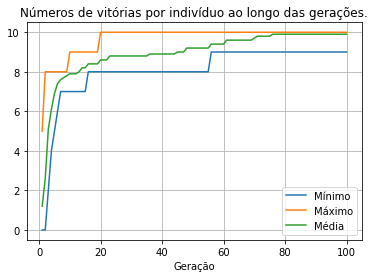

In [4]:
print_generations_graph(n_generations, ['Mínimo', 'Máximo', 'Média'],\
                        [min_win_arr, max_win_arr, avg_win_arr], 'Números de vitórias por indivíduo ao longo das gerações.')

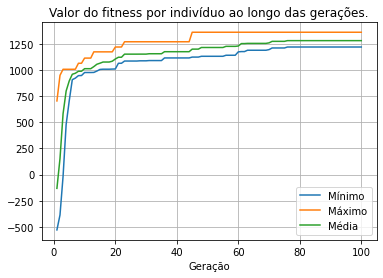

In [5]:
print_generations_graph(n_generations, ['Mínimo', 'Máximo', 'Média'],\
                        [min_fitness_arr, max_fitness_arr, avg_fitness_arr], 'Valor do fitness por indivíduo ao longo das gerações.')

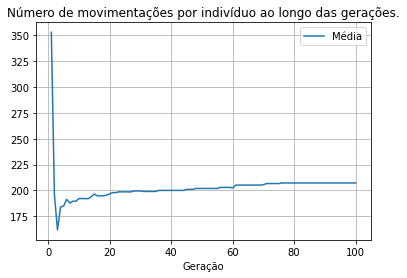

In [6]:
print_generations_graph(n_generations, ['Média'],\
                        [avg_movements_arr], 'Número de movimentações por indivíduo ao longo das gerações.')

In [7]:
best_gp_agent_smallClassic = population[0]
print('Melhor indivíduo da população final\nVitórias:', best_gp_agent_smallClassic.win_counter, '(de 10 partidas)',\
     '\nMédia da pontuação:', best_gp_agent_smallClassic.fitness, '\nMédia de movimentos:', best_gp_agent_smallClassic.avg_movements)

Melhor indivíduo da população final
Vitórias: 10 (de 10 partidas) 
Média da pontuação: 1361.3 
Média de movimentos: 204.1


Por meio do *log* da execução e dos gráficos apresentados podemos concluir os seguintes resultados.

O primeiro é o de que as curvas de taxas de vitórias acompanham as curvas de taxas de *fitness*. Esse é um resultado esperado, pois, como vimos na Seção 2.2.3, o valor do *fitness* de um indivíduo é calculado pela média das pontuações desse indivíduo em 10 partidas. Além disso, como afirmamos na Seção 1.1, 500 pontos são acrescidos à pontuação de um agente que obtém uma vitória e esta adição tem, na maioria das vezes, um impacto significativo na pontuação final.

Portanto, quando as taxas de vitória da popualação crescem, as taxas de pontuações também tendem a crescer. Nesse sentido, ao observarmos os dois primeiros gráficos, o crescimento mais abrupto ocorreu nas primeiras 10 gerações. A partir desse ponto, o desempenho geral da população subiu lentamente até convergir por volta da octagésima geração.

Em termos de quantidades de movimentos, vemos pelo terceiro gráfico que houve uma queda abrubta logo nas primeiras gerações e em seguida a quantidade média de movimentos da população permaneceu quase estável até a finalização do algoritmo.

Em particular, na última geração tivemos:

* Menor número de vitórias: 9 (de 10 partidas)
* Maior número de vitórias: 10 (de 10 partidas)
* Média de vitórias: 9.9 (de 10 partidas)
* Menor fitness: 1220.1
* Maior fitness: 1361.3
* Média do fitness: 1281.0
* Média de movimentos: 207.2

Observe que o indivíduo da última geração com menor quantidade de vitórias venceu 9 das 10 as partidas que disputou. Além disso, entre os indivíduos da última geração, aquele que obteve o melhor *fitness* também obteve o seguinte desempenho:

* Vitórias: 10 (de 10 partidas) 
* Média da pontuação: 1361.3
* Média de movimentos: 204.1

Portanto, concluímos que para o *layout* smallClassic, o nosso algoritmo de Programação Genética produziu bons agentes, entre os quais o melher deles (segundo o *fitness*) apresentou desempenho excelente ao vencer todas as partidas que disputou, com média de pontuação elevada e número de movimentos compatíveis com o mapa.

### 2.4.2 Mapa mediumClassic

Nesta Seção conduzimos os experimentos com o *layout* mediumClassic.

In [8]:
initialize_layout('mediumClassic')
population, min_win_arr, max_win_arr, avg_win_arr,\
min_fitness_arr, max_fitness_arr, avg_fitness_arr, avg_movements_arr =\
genetic_algorithm(n_generations, population_size, tree_max_depth, max_constant, n_offspring, n_mutations)

Geração #1
Menor número de vitórias: 0 (de 10 partidas)
Maior número de vitórias: 2 (de 10 partidas)
Média de vitórias: 0.7 (de 10 partidas)
Menor fitness: -672.7
Maior fitness: 567.9
Média do fitness: 150.45
Média de movimentos: 595.99

Geração #2
Menor número de vitórias: 0 (de 10 partidas)
Maior número de vitórias: 4 (de 10 partidas)
Média de vitórias: 1.5 (de 10 partidas)
Menor fitness: 233.9
Maior fitness: 619.1
Média do fitness: 428.78000000000003
Média de movimentos: 408.29

Geração #3
Menor número de vitórias: 1 (de 10 partidas)
Maior número de vitórias: 4 (de 10 partidas)
Média de vitórias: 1.7 (de 10 partidas)
Menor fitness: 385.7
Maior fitness: 619.1
Média do fitness: 466.4
Média de movimentos: 268.77

Geração #4
Menor número de vitórias: 1 (de 10 partidas)
Maior número de vitórias: 4 (de 10 partidas)
Média de vitórias: 1.9 (de 10 partidas)
Menor fitness: 430.4
Maior fitness: 637.7
Média do fitness: 538.39
Média de movimentos: 285.2

Geração #5
Menor número de vitórias: 1 (d

Geração #35
Menor número de vitórias: 2 (de 10 partidas)
Maior número de vitórias: 9 (de 10 partidas)
Média de vitórias: 5.0 (de 10 partidas)
Menor fitness: 848.9
Maior fitness: 1618.9
Média do fitness: 1011.3100000000001
Média de movimentos: 409.40999999999997

Geração #36
Menor número de vitórias: 2 (de 10 partidas)
Maior número de vitórias: 9 (de 10 partidas)
Média de vitórias: 5.0 (de 10 partidas)
Menor fitness: 848.9
Maior fitness: 1618.9
Média do fitness: 1011.3100000000001
Média de movimentos: 409.40999999999997

Geração #37
Menor número de vitórias: 2 (de 10 partidas)
Maior número de vitórias: 9 (de 10 partidas)
Média de vitórias: 5.0 (de 10 partidas)
Menor fitness: 848.9
Maior fitness: 1618.9
Média do fitness: 1011.3100000000001
Média de movimentos: 409.40999999999997

Geração #38
Menor número de vitórias: 2 (de 10 partidas)
Maior número de vitórias: 9 (de 10 partidas)
Média de vitórias: 5.0 (de 10 partidas)
Menor fitness: 848.9
Maior fitness: 1618.9
Média do fitness: 1011.310

Geração #68
Menor número de vitórias: 5 (de 10 partidas)
Maior número de vitórias: 9 (de 10 partidas)
Média de vitórias: 6.4 (de 10 partidas)
Menor fitness: 1285.6
Maior fitness: 1618.9
Média do fitness: 1376.72
Média de movimentos: 555.5800000000002

Geração #69
Menor número de vitórias: 5 (de 10 partidas)
Maior número de vitórias: 9 (de 10 partidas)
Média de vitórias: 6.6 (de 10 partidas)
Menor fitness: 1296.8
Maior fitness: 1618.9
Média do fitness: 1409.8700000000003
Média de movimentos: 568.9300000000001

Geração #70
Menor número de vitórias: 5 (de 10 partidas)
Maior número de vitórias: 9 (de 10 partidas)
Média de vitórias: 6.9 (de 10 partidas)
Menor fitness: 1308.2
Maior fitness: 1618.9
Média do fitness: 1434.7900000000004
Média de movimentos: 566.9999999999999

Geração #71
Menor número de vitórias: 6 (de 10 partidas)
Maior número de vitórias: 9 (de 10 partidas)
Média de vitórias: 7.1 (de 10 partidas)
Menor fitness: 1342.2
Maior fitness: 1618.9
Média do fitness: 1438.1900000000003

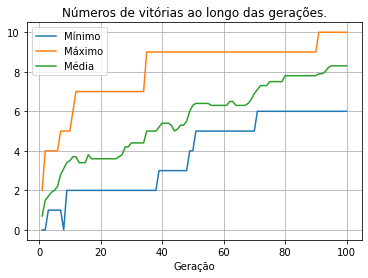

In [9]:
print_generations_graph(n_generations, ['Mínimo', 'Máximo', 'Média'],\
                        [min_win_arr, max_win_arr, avg_win_arr], 'Números de vitórias ao longo das gerações.')

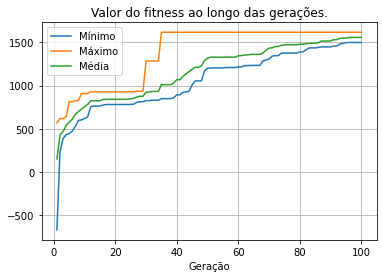

In [10]:
print_generations_graph(n_generations, ['Mínimo', 'Máximo', 'Média'],\
                        [min_fitness_arr, max_fitness_arr, avg_fitness_arr], 'Valor do fitness ao longo das gerações.')

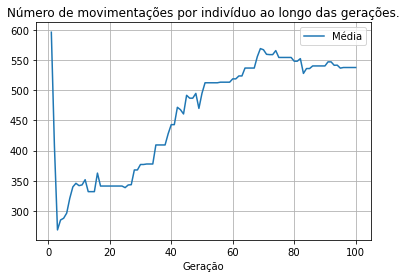

In [11]:
print_generations_graph(n_generations, ['Média'],\
                        [avg_movements_arr], 'Número de movimentações por indivíduo ao longo das gerações.')

In [12]:
best_gp_agent_mediumClassic = population[0]
print('Melhor indivíduo da população final\nVitórias:', best_gp_agent_mediumClassic.win_counter, '(de 10 partidas)',\
     '\nMédia da pontuação:', best_gp_agent_mediumClassic.fitness, '\nMédia de movimentos:', best_gp_agent_mediumClassic.avg_movements)

Melhor indivíduo da população final
Vitórias: 9 (de 10 partidas) 
Média da pontuação: 1618.9 
Média de movimentos: 625.5


Por meio do *log* da execução e dos gráficos apresentados podemos concluir os seguintes resultados.

Por meio do primeiro gráfico, verificamos que para o *layout* mediumClassic, em comparação com os resultados que obtivemos para o mapa smallClassic, a população apresentou um maior *gap* entre a quantidade de vitórias do indivíduo que mais venceu e do que menos venceu ao longo das gerações.

Adiante, podemos observar no segundo gráfico, que o *fitness* máximo da população convergiu cedo, por volta da trigésima geração. A partir desse ponto, a média de *fitness* mínimo e médio subiram gradativamente até quase alcançar o *fitness* máximo nas últimas gerações.

Em particular, na última geração tivemos:

* Menor número de vitórias: 6 (de 10 partidas)
* Maior número de vitórias: 10 (de 10 partidas)
* Média de vitórias: 8.3 (de 10 partidas)
* Menor fitness: 1500.5
* Maior fitness: 1618.9
* Média do fitness: 1558.61
* Média de movimentos: 537.6099999999999

Observe que, proporcionalmente, o *gap* entre o menor e maior *fitness* da última geração é bem menor que o *gap* entre o menor número e maior número de vitórias. Isso sugere que mesmo se tormarmos os indivíduos da última geração com baixa taxa de vitória (6 ou 7 vitórias apenas), veremos que mesmo perdendo, tais indivíduos alcançaram pontuações altas. De todo modo, a média de vitórias dos indivíduos da última geração é alta: 8,3 vitórias em 10 partidas, ou seja, 83% de sucesso nesse quesito.

Quanto à média do número de movimentos da população, verificamos por meio do terceiro gráfico que esse valor  ser estabilizou nas últimas gerações por volta de 550 movimentos. Isso é quase o dobro da média de movimentos observados no mapa smallClassic, o que era esperado, tendo em vista que o *layout* mediumClassic é aproximadamente duas vezes maior que o mapa smallClassic.

Ademais, observe que entre os indivíduos da última geração, aquele que obteve o melhor *fitness* também obteve 
* Vitórias: 9 (de 10 partidas) 
* Média da pontuação: 1618.9 
* Média de movimentos: 625.5

Portanto, concluímos que para o *layout* mediumClassic, o nosso algoritmo de Programação Genética produziu bons agentes, entre os quais o melher deles (segundo o *fitness*) apresentou desempenho excelente ao perder apenas uma das 10 partidas que disputou, com média de pontuação bastante elevada e número de movimentos compatíveis com o mapa.

### 2.4.3 Mapa originalClassic

Nesta Seção conduzimos os experimentos com o *layout* originalClassic.

In [13]:
initialize_layout('originalClassic')
population, min_win_arr, max_win_arr, avg_win_arr,\
min_fitness_arr, max_fitness_arr, avg_fitness_arr, avg_movements_arr =\
genetic_algorithm(n_generations, population_size, tree_max_depth, max_constant, n_offspring, n_mutations)

Geração #1
Menor número de vitórias: 0 (de 10 partidas)
Maior número de vitórias: 10 (de 10 partidas)
Média de vitórias: 1.1 (de 10 partidas)
Menor fitness: -378.1
Maior fitness: 2731.5
Média do fitness: 511.16999999999996
Média de movimentos: 2530.74

Geração #2
Menor número de vitórias: 0 (de 10 partidas)
Maior número de vitórias: 10 (de 10 partidas)
Média de vitórias: 2.2 (de 10 partidas)
Menor fitness: 87.3
Maior fitness: 2731.5
Média do fitness: 1173.84
Média de movimentos: 1581.05

Geração #3
Menor número de vitórias: 0 (de 10 partidas)
Maior número de vitórias: 10 (de 10 partidas)
Média de vitórias: 2.3 (de 10 partidas)
Menor fitness: 754.9
Maior fitness: 2731.5
Média do fitness: 1343.85
Média de movimentos: 1411.5500000000002

Geração #4
Menor número de vitórias: 0 (de 10 partidas)
Maior número de vitórias: 10 (de 10 partidas)
Média de vitórias: 2.7 (de 10 partidas)
Menor fitness: 1034.9
Maior fitness: 2742.6
Média do fitness: 1696.8200000000002
Média de movimentos: 1366.979999

Geração #34
Menor número de vitórias: 7 (de 10 partidas)
Maior número de vitórias: 9 (de 10 partidas)
Média de vitórias: 7.8 (de 10 partidas)
Menor fitness: 3227.3
Maior fitness: 3567.1
Média do fitness: 3378.7700000000004
Média de movimentos: 2381.12

Geração #35
Menor número de vitórias: 7 (de 10 partidas)
Maior número de vitórias: 9 (de 10 partidas)
Média de vitórias: 7.8 (de 10 partidas)
Menor fitness: 3227.3
Maior fitness: 3567.1
Média do fitness: 3378.7700000000004
Média de movimentos: 2381.12

Geração #36
Menor número de vitórias: 7 (de 10 partidas)
Maior número de vitórias: 9 (de 10 partidas)
Média de vitórias: 7.8 (de 10 partidas)
Menor fitness: 3227.3
Maior fitness: 3567.1
Média do fitness: 3378.7700000000004
Média de movimentos: 2381.12

Geração #37
Menor número de vitórias: 7 (de 10 partidas)
Maior número de vitórias: 9 (de 10 partidas)
Média de vitórias: 7.8 (de 10 partidas)
Menor fitness: 3227.3
Maior fitness: 3567.1
Média do fitness: 3378.7700000000004
Média de movimento

Geração #67
Menor número de vitórias: 7 (de 10 partidas)
Maior número de vitórias: 8 (de 10 partidas)
Média de vitórias: 7.8 (de 10 partidas)
Menor fitness: 3349.0
Maior fitness: 3567.1
Média do fitness: 3427.29
Média de movimentos: 2396.01

Geração #68
Menor número de vitórias: 7 (de 10 partidas)
Maior número de vitórias: 8 (de 10 partidas)
Média de vitórias: 7.7 (de 10 partidas)
Menor fitness: 3350.7
Maior fitness: 3567.1
Média do fitness: 3441.66
Média de movimentos: 2417.13

Geração #69
Menor número de vitórias: 7 (de 10 partidas)
Maior número de vitórias: 8 (de 10 partidas)
Média de vitórias: 7.7 (de 10 partidas)
Menor fitness: 3350.7
Maior fitness: 3567.1
Média do fitness: 3441.66
Média de movimentos: 2417.13

Geração #70
Menor número de vitórias: 7 (de 10 partidas)
Maior número de vitórias: 8 (de 10 partidas)
Média de vitórias: 7.7 (de 10 partidas)
Menor fitness: 3350.7
Maior fitness: 3567.1
Média do fitness: 3441.66
Média de movimentos: 2417.13

Geração #71
Menor número de vitó

Geração #99
Menor número de vitórias: 7 (de 10 partidas)
Maior número de vitórias: 10 (de 10 partidas)
Média de vitórias: 8.0 (de 10 partidas)
Menor fitness: 3399.8
Maior fitness: 3862.3
Média do fitness: 3512.29
Média de movimentos: 2462.4100000000003

Geração #100
Menor número de vitórias: 7 (de 10 partidas)
Maior número de vitórias: 10 (de 10 partidas)
Média de vitórias: 8.0 (de 10 partidas)
Menor fitness: 3399.8
Maior fitness: 3862.3
Média do fitness: 3512.29
Média de movimentos: 2462.4100000000003



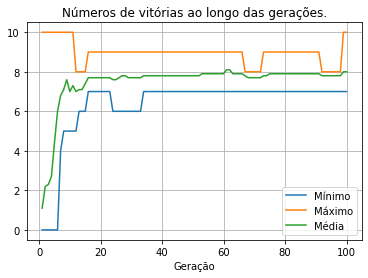

In [14]:
print_generations_graph(n_generations, ['Mínimo', 'Máximo', 'Média'],\
                        [min_win_arr, max_win_arr, avg_win_arr], 'Números de vitórias ao longo das gerações.')

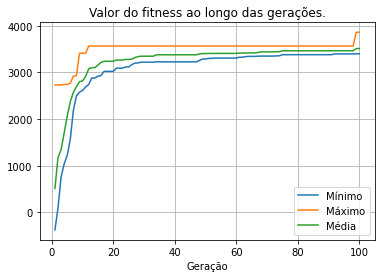

In [15]:
print_generations_graph(n_generations, ['Mínimo', 'Máximo', 'Média'],\
                        [min_fitness_arr, max_fitness_arr, avg_fitness_arr], 'Valor do fitness ao longo das gerações.')

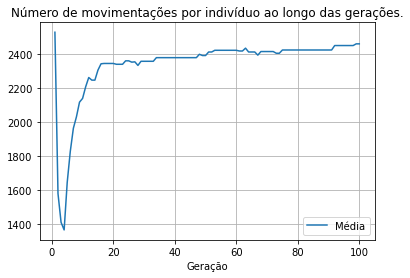

In [16]:
print_generations_graph(n_generations, ['Média'],\
                        [avg_movements_arr], 'Número de movimentações por indivíduo ao longo das gerações.')

In [17]:
best_gp_agent_originalClassic = population[0]
print('Melhor indivíduo da população final\nVitórias:', best_gp_agent_originalClassic.win_counter, '(de 10 partidas)',\
     '\nMédia da pontuação:', best_gp_agent_originalClassic.fitness, '\nMédia de movimentos:', best_gp_agent_originalClassic.avg_movements)

Melhor indivíduo da população final
Vitórias: 10 (de 10 partidas) 
Média da pontuação: 3862.3 
Média de movimentos: 2634.5


Por meio do *log* da execução e dos gráficos apresentados podemos concluir os seguintes resultados.

Por meio do primeiro gráfico, verificamos que para o *layout* originalClassic, a partir da 40ª geração, a população apresentou um *gap* estável entre a quantidade de vitórias do indivíduo que mais venceu e do que menos venceu. A partir da 40ª geração, as taxas de menor número de vitórias e média do número de vitórias convergiram, embora a taxa de número máximo de vitórias tenha sofrido variações entre 8 e 10 até o fim da execução do algoritmo.

Adiante, podemos observar no segundo gráfico, que o *fitness* máximo da população convergiu cedo, por volta da vigésima geração. A partir desse ponto, a média de *fitness* mínimo e médio subiram gradativamente até quase alcançar o *fitness* máximo nas últimas gerações.

Em particular, na última geração tivemos:

* Menor número de vitórias: 7 (de 10 partidas)
* Maior número de vitórias: 10 (de 10 partidas)
* Média de vitórias: 8.0 (de 10 partidas)
* Menor fitness: 3399.8
* Maior fitness: 3862.3
* Média do fitness: 3512.29
* Média de movimentos: 2462.4100000000003

Observe que, proporcionalmente, o *gap* entre o menor e maior *fitness* da última geração é bem menor que o *gap* entre o menor número e maior número de vitórias. Isso sugere que mesmo se tormarmos os indivíduos da última geração com baixa taxa de vitória (7 vitórias apenas), veremos que mesmo perdendo, tais indivíduos alcançaram pontuações altas. De todo modo, a média de vitórias dos indivíduos da última geração é alta: 8,0 vitórias em 10 partidas, ou seja, 80% de sucesso nesse quesito.

Quanto à média do número de movimentos da população, verificamos por meio do terceiro gráfico que esse valor  ser estabilizou nas últimas gerações por volta de 2400 movimentos. Consideramos que este número é bastante elevado, mesmo sabendo que o originalClassic é o maior dos nossos *layouts*. Contudo, ressaltamos que esse é um valor compatível com o mapa, pois podem ocorrer situações em que o agente tem que percorrer longas distâncias para alcançar itens de comida que ficaram isolados.

Ademais, observe que entre os indivíduos da última geração, aquele que obteve o melhor *fitness* também obteve 
* Vitórias: 10 (de 10 partidas) 
* Média da pontuação: 3862.3 
* Média de movimentos: 2634.5

Portanto, concluímos que para o *layout* originalClassic, o nosso algoritmo de Programação Genética produziu bons agentes, entre os quais o melher deles (segundo o *fitness*) apresentou desempenho excelente ao vencer todas as 10 partidas que disputou, com média de pontuação bastante elevada e número de movimentos compatíveis com o mapa.

# 3 Parte $II$ - Aprendizado por Reforço

Nesta seção, realizamos experimentos de aprendizagem por reforço para os mesmos três *layouts* analisados com programação genética. O algoritmo de aprendizado por reforço escolhido foi o q-learning. 
À princípio, escolhemos uma formulação que gerou um espaço de estados muito grande. Por consequência, o processo de treinamento muito rapidamente estourou a capacidade de memória das máquinas em que os experimentos foram realizados. Isso fez com que fosse possível treinar apenas com um número reduzido de episódios, em espeical os *layouts* maiores. (3000 episódios para o *layout* smallClassic, 3000 para o mediumClassic e 1000 para o originalClassic).
Essa limitação nos impulsionou a tentar uma modelagem alternativa, com um espaço de estados de tamanho reduzido. Nesse segundo caso, foi possível treinar com um número razoavelmente mais significativo de episódios (10000 para o *layout* smallClassic, 10000 para o mediumClassic e 3000 para o originalClassic)

Além disso, fizemos também uma implementação do q-learning com aproximador de função. Para esse caso, os estados foram representados como uma combinação de *features*, cada *feature* sendo associada a um peso, e a q-table foi atualizada a partir de uma combinação linear dessas *features*. 

## 3.1 Q-learning
Nesta subseção, apresentamos as duas tentativas realizadas utilizando o algoritmo q-learning. Em ambas, a política de exploração adotada foi $\epsilon$-greedy. Além disso, a atualização da q-table foi feita a partir da seguinte fórmula:

$$
Q(s,a) = Q(s,a) + \alpha [R(s,a) + \gamma\max_{a^\prime} Q(s^\prime, a^\prime) - Q(s,a)],
$$

em que:
$s$ é o estado atual,
$a$ é a ação tomada,
$s^\prime$ é o estado obtido após tomar a ação $a$, e
$R(s,a)$ é o reforço obtido ao alcançar o estado $s^\prime$,
$\alpha$ é a taxa de aprendizado, e
$\gamma$ é o índice de desconto.

### 3.1.1 Primeira formulação
Nessa primeira tentativa, tentamos utilizar como referência todas as informações contidas no mapa todo.
A seguir, apresentamos a formulação de Markov adotada. 

##### $\rightarrow$ Espaço de estados
Um estado é definifo basicamente como uma fotografia do mapa em um dado instante de tempo. Ele contém:
- a posição do pacman;
- as posições dos itens de comida;
- as posições das cápsulas;
- as posições dos fantasmas ativos;
- as posições dos fantasmas comestíveis;
- as posições das paredes;
- as posições "vazias".

Na nossa implementação, representamos cada estado por uma *string*, em que cada caractere representa uma posição do mapa e indica qual tipo de objeto está naquela posição, naquele estado. A relação entre caracteres e tipo de objeto é dada da seguinte forma:
- P: pacman;
- F: item de comida;
- C: cápsula;
- A: fantasma ativos;
- S: fantasma comestível;
- W: parede;
- E: posições vazias.

Sejam $m$ e $n$ as dimensões de um dado *layout*. Note que, nessa formulação, o número de estados diferentes é dado pelo número de permutações possíveis, de tamanho $m \times n$, do conjunto de caracteres necessários para representar um estado. Essa quantidade de estados diferentes é bastante grande.

##### $\rightarrow$ Espaço de ações
Cada ação é um dos movimentos que o pacman pode realizar. São elas:
- NORTH,
- SOUTH,
- WEST,
- EAST,
- STOP.
    
##### $\rightarrow$ Função de reforço
Para cada ação que o pacman pode realizar, associamos um valor de reforço. O reforço referente ao passar do tempo, de -1 para cada passo, já vem com o funcionamento padrão do *framework* utilizado. Os demais reforços foram definidos da seguinte maneira:
- +500, quando a ação resulta em uma vitória do pacman;
- -500, quando a ação resulta em uma derrota do pacman;
- +10, quando a ação do pacman resulta no consumo de um item de comida;
- +100, quando a ação do pacman resulta no consumo de uma cápsula;
- +200, quando a ação do pacman resulta no consumo de um fantasma comestível;
- -1, quando o pacman não se movimenta;
- 0, caso contrário.

##### $\rightarrow$ Episódios  e critério de parada
Um episódio se encerra (critério de parada) quando o pacman ganha ou perde o jogo.
O número diferente de episódios usados para o treinamento de cada *layout* se encontra na subseção em que relatamos os experimentos realizados.

##### $\rightarrow$ Parâmetros utilizados
Para todos os layouts, utilizamos os seguintes parâmetros para implementação do q-learning:
- taxa de aprendizado: alpha = 0.5,
- índice de desconto: gamma = 0.8.

Além disso, como utilizamos a política $\epsilon$-greedy, foi preciso ajustar também o seguinte parâmetro:
- taxa de exploração: epsilon = 0.2, decaindo de 0.001 até chegar em zero ou o treinamento se encerrar.

### 3.1.2 Segunda formulação
Nessa segunda tentativa, tentamos utilizar como referência todas as informações contidas apenas no entorno da posição atual do pacman, adotando a ideia de vizinhança-8. Ou seja, supondo que o pacman está na posição $(x,y)$, um estado é formado pelas seguintes posições: 

$(x+1,y-1)$, $(x+1,y)$, $(x+1,y+1)$, $(x,y-1)$, $(x,y+1)$, $(x-11,y-1)$, $(x-1,y)$ e $(x-1,y+1)$. 

No *framework* adotado para executar o jogo do pacman, o grid que representa um mapa segue como referência o plano euclidiano (discretizado), com a origem posicionada no canto inferior esquerdo, o eixo evrtical crescento para cima e o eixo horizontal crescendo para a direita. 
A seguir, apresentamos a formulação de Markov adotada. Note que, esse padrão não é o normalmente utilizado para indexar matrizes, no entanto, por simplicidade, optamos por seguir o padrão do modelo.

##### $\rightarrow$ Espaço de estados
Similarmente à tentativa anterior, um estado é definifo basicamente como uma fotografia do entorno do pacman em um dado instante de tempo. Ele contém:
- a posição do pacman;
- as posições dos itens de comida;
- as posições das cápsulas;
- as posições dos fantasmas ativos;
- as posições dos fantasmas comestíveis;
- as posições das paredes;
- as posições "vazias".

Novamente, representamos cada estado por uma *string*, em que cada caractere representa uma posição do mapa e indica qual tipo de objeto está naquela posição, naquele estado. Além dos caracteres listados na formulação anterior, para essa formulação, precisamos de um caractere extra para representar os limites do mapa. Assim, as posições ao entorno do pacman que se encontram fora do limite do mapa são marcadas com o caratere 'O'. Note que, nessa formulação, um estado é representado por uma *string* de apenas oito caracteres. Portanto, o número de estados diferentes é dado pelo número de permutações possíveis, de tamanho oito, do conjunto de caracteres necessários para representar um estado. Dessa maneira, o número de estados diferentes nessa formulação é  significativamente menor que o número de estados diferentes possíveis na formulação anterior.

##### $\rightarrow$ Espaço de ações
Cada ação é um dos movimentos que o pacman pode realizar. São elas:
- NORTH,
- SOUTH,
- WEST,
- EAST,
- STOP.
    
##### $\rightarrow$ Função de reforço
Para cada ação que o pacman pode realizar, associamos um valor de reforço. O reforço referente ao passar do tempo, de -1 para cada passo, já vem com o funcionamento padrão do *framework* utilizado. Os reforços foram definidos da seguinte maneira:
- +500, quando a ação resulta em uma vitória do pacman;
- -500, quando a ação resulta em uma derrota do pacman;
- +10, quando a ação do pacman resulta no consumo de um item de comida;
- +100, quando a ação do pacman resulta no consumo de uma cápsula;
- +200, quando a ação do pacman resulta no consumo de um fantasma comestível;
- -1, quando o pacman não se movimenta;
- 0, caso contrário.

##### $\rightarrow$ Episódios  e critério de parada
Um episódio se encerra (critério de parada) quando o pacman ganha ou perde o jogo. O número de episódios utilizados para o treinamento está apresentado na subseção em que relatamos os experimentos realizados com essa formulação.

##### $\rightarrow$ Parâmetros utilizados
Para todos os layouts, utilizamos os seguintes parâmetros para implementação do q-learning:
- taxa de aprendizado: alpha = 0.5,
- índice de desconto: gamma = 0.8.

Além disso, como utilizamos a política $\epsilon$-greedy, foi preciso ajustar também o seguinte parâmetro:
- taxa de exploração: epsilon = 0.2, decaindo de 0.001 até chegar em zero ou o treinamento se encerrar.

## 3.2 Q-learning com aproximador de função
Nesta subseção, apresentamos a nossa tentativa de implementar o algoritmo q-learning com aproximador de função. Nesse caso, foi necessário definir *features* associadas a um par estado-ação. A ideia é que cada uma dessas *features* seja associada a um peso e, então, o q-value é atualizado como uma combinação linear dos valores das *features*. Assim, a q-table é atualizada da seguinte forma:

$$
Q(s,a) = \sum_{i=1}^n w_i f_i (s,a),
$$

em que: $s$ é o estado atual, $a$ é a ação tomada, $w_i$ é o peso da $i$-ésima *feature* e $f_i (s,a)$ é o valor da $i$-ésima *feature* para o par estado-ação $s$-$a$.

Os pesos também devem ser atualizados a cada episódio e é justamente na atualização dos pesos que são considerados o reforço e a previsão do melhor futuro possível. Cada pesso $w_i$ é atualizado da seguinte forma:

$$
w_i = w_i + \alpha [R(s,a) + \gamma\max_{a^\prime} Q(s^\prime, a^\prime) - Q(s,a)] f_i(s,a),
$$

em que: $R(s,a)$ é o reforço associado ao estado $s^\prime$, $\alpha$ é a taxa de aprendizado e $\gamma$ é o índice de desconto.

Para escolher as *features* nos baseamos no trabalho [8]. A seguir, apresentamos as *features* definidas, bem como demais componentes da formulação. Todas as distâncias foram calculadas como distância de Manhattan.

##### $\rightarrow$ Features
- Distancia para o item de comida mais próximo.
- Distância para o fantasma comestível mais próximo.
- Distância para o fantasma ativo mais próximo.
- Progresso da partida, dado pela razão entre o número total de itens de comida e o número de itens consumidos.
- Se o pacman comeu uma cápsula, tempo restante até que os fantasmas deixem de ser comestíveis.

##### $\rightarrow$ Espaço de ações
Cada ação é um dos movimentos que o pacman pode realizar. São elas:
- NORTH,
- SOUTH,
- WEST,
- EAST,
- STOP.
    
##### $\rightarrow$ Função de reforço
Para cada ação que o pacman pode realizar, associamos um valor de reforço. O reforço referente ao passar do tempo, de -1 para cada passo, já vem com o funcionamento padrão do *framework* utilizado. Os demais reforços foram definidos da seguinte maneira:
- +500, quando a ação resulta em uma vitória do pacman;
- -500, quando a ação resulta em uma derrota do pacman;
- +10, quando a ação do pacman resulta no consumo de um item de comida;
- +100, quando a ação do pacman resulta no consumo de uma cápsula;
- +200, quando a ação do pacman resulta no consumo de um fantasma comestível;
- -1, quando o pacman não se movimenta;
- 0, caso contrário.

##### $\rightarrow$ Episódios  e critério de parada
Um episódio se encerra (critério de parada) quando o pacman ganha ou perde o jogo. O número de episódios utilizados para o treinamento está apresentado na subseção em que relatamos os experimentos realizados com essa formulação.

##### $\rightarrow$ Parâmetros utilizados
Para todos os layouts, utilizamos os seguintes parâmetros para implementação do q-learning:
- taxa de aprendizado: alpha = 0.5,
- índice de desconto: gamma = 0.8.

Além disso, como utilizamos a política $\epsilon$-greedy, foi preciso ajustar também o seguinte parâmetro:
- taxa de exploração: epsilon = 0.2, decaindo de 0.001 até chegar em zero ou o treinamento se encerrar.


## 3.3 Código-fonte

A seguir, apresentamos todo o código-fonte referentes à parte $II$ do projeto.

In [2]:
from pacman import *
import numpy as np
import random
import math
import util
from game import Directions
from game import Agent
import matplotlib.pyplot as plt 

In [9]:
# Implementação do agente para a primeira formulação #
class RLAgent_full(Agent):
    qtable = {}
    alpha = 0.5
    gamma = 0.8
    epsilon = 0.2
    scores_list = []
    nsteps_list = []
    result_list = []
    reward_list = []
    episode_reward = 0
    m = 0
    n = 0
        
    def calculateReward(self, state, future_state):
        future_pacman = list(future_state.getPacmanPosition())
        reward = 0
        if future_state.isWin(): #pacman ganhou
            reward = 500
        if future_state.isLose(): #pacman perdeu
            reward = -500
        if state.hasFood(future_pacman[0], future_pacman[1]): #comeu um item de comida
            reward = 10
        if future_state.getPacmanPosition() in state.getCapsules(): #comeu uma cápsula
            reward = 100
        for i in range(1,state.getNumAgents()): #comeu fantasma assustado
            if (future_pacman[0], future_pacman[1]) == state.getGhostPosition(i) and state.data.agentStates[i].scaredTimer > 1:
                reward = 200
        if state.getPacmanPosition() == future_state.getPacmanPosition(): #não se mexeu
            reward = -1
        
        return reward
    
    def update(self, state, action, qstate):
        future_state = state.generatePacmanSuccessor(action)
        
        reward = self.calculateReward(state, future_state)
        self.episode_reward += reward
        
        if (future_state.isWin() or future_state.isLose()):
            max_future = 0
        else:
            future_qstate = _generate_qstate_key(future_state, self.m, self.n)       
            future_action = self.getBestActionFromQtable(future_state, future_qstate)
            max_future = self.qtable[(future_qstate,future_action)]
        
        if (qstate,action) not in self.qtable:
                self.qtable[(qstate,action)] = 0
        old_value = self.qtable[(qstate,action)]
        
        new_value = old_value + self.alpha*(reward + self.gamma*max_future - old_value)
        self.qtable[(qstate,action)] = new_value
    
    def getBestActionFromQtable(self, state, qstate):
        best_action = Directions.STOP
        max_qvalue = -math.inf
        
        legalActions = state.getLegalPacmanActions()
        for action in legalActions:
            if (qstate,action) not in self.qtable:
                self.qtable[(qstate,action)] = 0
            if self.qtable[(qstate,action)] > max_qvalue:
                max_qvalue = self.qtable[(qstate,action)]
                best_action = action
            
        return best_action
    
    def getQAction(self, state, qstate):
        legalActions = state.getLegalPacmanActions()
        
        # epsilon-greedy policy
        p = random.random()
        if p < self.epsilon:
            action = random.choice(legalActions)
        else:
            action = self.getBestActionFromQtable(state, qstate)

        return action
   
    
    def getAction(self, state):
        qstate = _generate_qstate_key(state, self.m, self.n)
        action = self.getQAction(state, qstate)
        self.update(state, action, qstate)
        return action     

        
def _get_qstate_key_char(state, x, y):
    if (x,y) in state.getGhostPositions():
        c = 'A' # fantasma ativo
        for i in range(1,state.getNumAgents()):
            if (x,y) == state.getGhostPosition(i) and state.data.agentStates[i].scaredTimer > 1:
                c = 'S' # fantasma assustado
        return c
    elif (x,y) in state.getCapsules():
        return 'C'
    elif (state.hasFood(x,y)):
        return 'F'
    elif (state.hasWall(x,y)):
        return 'W'
    elif (x,y) == state.getPacmanPosition():
        return 'P'
    else:
        return 'E'

def _generate_qstate_key(state, m, n):
    qstate = []
    for i in range(0,m):
        for j in range(0,n):
            qstate.append(_get_qstate_key_char(state, i, j))
    
    return ''.join(qstate)
  
def print_episodes_graph(n_episodes, values, label_y, title):
    ep = list(range(1,n_episodes+1))
    
    plt.plot(ep,values)
    plt.title(title)
    plt.xlabel('Episódios')
    plt.ylabel(label_y)
    plt.grid()
    plt.show()

In [10]:
# Implementação do agente para a segunda formulação #
class RLAgent_mini(Agent):
    qtable = {}
    alpha = 0.5
    gamma = 0.8
    epsilon = 0.2
    scores_list = []
    nsteps_list = []
    result_list = []
    reward_list = []
    episode_reward = 0
    m = 0
    n = 0
        
    def calculateReward(self, state, future_state):
        future_pacman = list(future_state.getPacmanPosition())
        reward = 0
        if future_state.isWin(): #pacman ganhou
            reward = 500
        if future_state.isLose(): #pacman perdeu
            reward = -500
        if state.hasFood(future_pacman[0], future_pacman[1]): #comeu um item de comida
            reward = 10
        if future_state.getPacmanPosition() in state.getCapsules(): #comeu uma cápsula
            reward = 100
        for i in range(1,state.getNumAgents()): #comeu fantasma assustado
            if (future_pacman[0], future_pacman[1]) == state.getGhostPosition(i) and state.data.agentStates[i].scaredTimer > 1:
                reward = 200
        if state.getPacmanPosition() == future_state.getPacmanPosition(): #não se mexeu
            reward = -1
        
        return reward
    
    def update(self, state, action, qstate):
        future_state = state.generatePacmanSuccessor(action)
        
        reward = self.calculateReward(state, future_state)
        self.episode_reward += reward  
        
        if (future_state.isWin() or future_state.isLose()):
            max_future = 0
        else:
            future_qstate = generate_qstate_key(future_state, self.m, self.n)       
            future_action = self.getBestActionFromQtable(future_state, future_qstate)
            max_future = self.qtable[(future_qstate,future_action)]
        
        if (qstate,action) not in self.qtable:
                self.qtable[(qstate,action)] = 0
        old_value = self.qtable[(qstate,action)]
        
        new_value = old_value + self.alpha*(reward + self.gamma*max_future - old_value)
        self.qtable[(qstate,action)] = new_value
    
    def getBestActionFromQtable(self, state, qstate):
        best_action = Directions.STOP
        max_qvalue = -math.inf
        
        legalActions = state.getLegalPacmanActions()
        for action in legalActions:
            if (qstate,action) not in self.qtable:
                self.qtable[(qstate,action)] = 0
            if self.qtable[(qstate,action)] > max_qvalue:
                max_qvalue = self.qtable[(qstate,action)]
                best_action = action
            
        return best_action
    
    def getQAction(self, state, qstate):
        legalActions = state.getLegalPacmanActions()
        
        # epsilon-greedy policy
        p = random.random()
        if p < self.epsilon:
            action = random.choice(legalActions)
        else:
            action = self.getBestActionFromQtable(state, qstate)
        
        return action
   
    
    def getAction(self, state):
        qstate = generate_qstate_key(state, self.m, self.n)
        action = self.getQAction(state, qstate)
        self.update(state, action, qstate)
        return action
        
def get_qstate_key_char(state, x, y):
    
    if (x,y) in state.getGhostPositions():
        c = 'A' # fantasma ativo
        for i in range(1,state.getNumAgents()):
            if (x,y) == state.getGhostPosition(i) and state.data.agentStates[i].scaredTimer > 1:
                c = 'S' # fantasma assustado
        return c
    elif (x,y) in state.getCapsules():
        return 'C'
    elif (state.hasFood(x,y)):
        return 'F'
    elif (state.hasWall(x,y)):
        return 'W'
    elif (x,y) == state.getPacmanPosition():
        return 'P'
    else:
        return 'E'

def generate_qstate_key(state, m, n):
    key = ['O','O','O','O','O','O','O','O']
    pacman = list(state.getPacmanPosition())
    
    # canto superior esquerdo key[0]
    x = pacman[0]-1
    y = pacman[1]+1
    if x >= 1 and y <= m:
        key[0] = get_qstate_key_char(state, x, y)
    
    # meio superior key[1]
    x = pacman[0]
    y = pacman[1]+1
    if y <= m:
        key[1] = get_qstate_key_char(state, x, y)
        
    # canto superior direito key[2]
    x = pacman[0]+1
    y = pacman[1]+1
    if x <= n and y <= m:
        key[2] = get_qstate_key_char(state, x, y)
    
    # meio esquerdo key[3]
    x = pacman[0]-1
    y = pacman[1]
    if x >= 1:
        key[3] = get_qstate_key_char(state, x, y)

    # meio direito key[4]
    x = pacman[0]+1
    y = pacman[1]
    if x <= n:
        key[4] = get_qstate_key_char(state, x, y)
    
    # canto inferior esquerdo key[5]
    x = pacman[0]-1
    y = pacman[1]-1
    if x >= 1 and y >=1:
        key[5] = get_qstate_key_char(state, x, y)
        
    # meio inferior key[6]
    x = pacman[0]
    y = pacman[1]-1
    if y >= 1:
        key[6] = get_qstate_key_char(state, x, y)
    
    # canto inferior direito key[7]
    x = pacman[0]+1
    y = pacman[1]-1
    if x <= n and y >= 1:
        key[7] = get_qstate_key_char(state, x, y)
    
    return ''.join(key)

In [11]:
# Implementação do agente para a terceira formulação #
def _get_qstate_key_char(state, x, y):
    if (x,y) in state.getGhostPositions():
        c = 'A' # fantasma ativo
        for i in range(1,state.getNumAgents()):
            if (x,y) == state.getGhostPosition(i) and state.data.agentStates[i].scaredTimer > 1:
                c = 'S' # fantasma assustado
        return c
    elif (x,y) in state.getCapsules():
        return 'C'
    elif (state.hasFood(x,y)):
        return 'F'
    elif (state.hasWall(x,y)):
        return 'W'
    elif (x,y) == state.getPacmanPosition():
        return 'P'
    else:
        return 'E'

def _generate_qstate_key(state, m, n):
    qstate = []
    for i in range(0,m):
        for j in range(0,n):
            qstate.append(_get_qstate_key_char(state, i, j))
    
    return ''.join(qstate)

def getFeatureCapsule(state, future_state):
    max_scared = 0
    for i in range(1,state.getNumAgents()):
        if state.data.agentStates[i].scaredTimer > max_scared:
            max_scared = state.data.agentStates[i].scaredTimer
    if max_scared > 0:
        return 1 - (39 - max_scared)/39
    else:
        return 0

def getFeatureActive_g(state, future_state):
    nearest_ghost = math.inf
    for i in range(1,state.getNumAgents()):
        if state.data.agentStates[i].scaredTimer <= 1:
            if util.manhattanDistance(state.getPacmanPosition(), state.getGhostPosition(i)) < nearest_ghost:
                nearest_ghost = util.manhattanDistance(state.getPacmanPosition(), state.getGhostPosition(i))
    
    if nearest_ghost != math.inf:
        return nearest_ghost
    else:
        return 0

def getFeatureScared_g(state, future_state):
    nearest_ghost = math.inf
    for i in range(1,state.getNumAgents()):
        if state.data.agentStates[i].scaredTimer > 1:
            if util.manhattanDistance(state.getPacmanPosition(), state.getGhostPosition(i)) < nearest_ghost:
                nearest_ghost = util.manhattanDistance(state.getPacmanPosition(), state.getGhostPosition(i))
    
    if nearest_ghost != math.inf:
        return nearest_ghost
    else:
        return 0

class Params():
    bias = 1
    food = 0
    capsule = 0
    scared_g = 0
    active_g = 0
    proggress = 0

class RL_AQ_Agent(Agent):
    m = 0
    n = 0
    total_food = 0
    epsilon = 0.2
    alpha = 0.5
    gamma = 0.8
    episode_reward = 0
    qtable = {}
    ftable = {}
    wtable = {}
    nsteps_list = []
    reward_list = []
    scores_list = []
    result_list = []
    

    def getFeatureFood(self, state, future_state):
        nearest_food = math.inf
        food = state.getFood()
        for i in range(1,self.m):
            for j in range(1,self.n):
                if food[i][j]:
                    c_food = util.manhattanDistance(state.getPacmanPosition(), (i,j))
                    if c_food < nearest_food:
                        nearest_food = c_food
        
        if nearest_food != math.inf:
            return nearest_food
        else:
            return 0

    def getFeatureProggress(self, future_state):
        return future_state.getNumFood()/self.total_food
    
    def calculateReward(self, state, future_state):
        future_pacman = list(future_state.getPacmanPosition())
        reward = 0
        
        if future_state.isWin(): #pacman ganhou
            reward = 500
        if future_state.isLose(): #pacman perdeu
            reward = -500
        if future_state.getPacmanPosition() in state.getCapsules(): #comeu uma cápsula
            reward = 100
        for i in range(1,state.getNumAgents()): #comeu fantasma assustado
            if (future_pacman[0], future_pacman[1]) == state.getGhostPosition(i) and state.data.agentStates[i].scaredTimer > 1:
                reward = 200
        if state.getPacmanPosition() == future_state.getPacmanPosition(): #não se mexeu
            reward = -1
        if state.hasFood(future_pacman[0], future_pacman[1]): #comeu um item de comida
            reward = 100
        #print("REWARD: ", reward)
        return reward
        
    def calculateFeatures(self, state, action, future_state):
        qstate = _generate_qstate_key(state, self.m, self.n)
        future_qstate = _generate_qstate_key(future_state, self.m, self.n)
                
        if (qstate,action) not in self.ftable:
            self.ftable[(qstate,action)] = Params()
        self.ftable[(qstate,action)].food = self.getFeatureFood(state, future_state)
        self.ftable[(qstate,action)].capsule = getFeatureCapsule(state, future_state)
        self.ftable[(qstate,action)].active_g = getFeatureActive_g(state, future_state)
        self.ftable[(qstate,action)].scared_g = getFeatureScared_g(state, future_state)
        self.ftable[(qstate,action)].proggress = self.getFeatureProggress(future_state)

    def updateQtable(self, state, action):
        #obtain future state
        future_state = state.generatePacmanSuccessor(action)
        future_qstate = _generate_qstate_key(future_state, self.m, self.n)
        current_qstate = _generate_qstate_key(state, self.m, self.n)
        
        #initialize qtable, if necessary
        if (current_qstate,action) not in self.qtable:
            self.qtable[(current_qstate,action)] = 0
        
        #wait for ghosts movements to be complete
        
        #calculate reward
        action_reward = self.calculateReward(state, future_state)
        self.episode_reward += action_reward
        
        #calculate best action for future_state
        if future_state.getLegalPacmanActions() == []:
            future_best_value = 0
        else:
            future_best_action = self.getActionFromQtable(future_state)
            future_best_value = self.qtable[(future_qstate,future_best_action)]
            
        #calculate features
        self.calculateFeatures(state, action, future_state)
        #print("Features: ", self.ftable[(current_qstate,action)].bias)
        #print("Features: ", self.ftable[(current_qstate,action)].food)
        #print("Features: ", self.ftable[(current_qstate,action)].capsule)
        #print("Features: ", self.ftable[(current_qstate,action)].active_g)
        #print("Features: ", self.ftable[(current_qstate,action)].scared_g)
        #print("Features: ", self.ftable[(current_qstate,action)].proggress)
        
        #update weights
        if (current_qstate,action) not in self.wtable:
            self.wtable[(current_qstate,action)] = Params()
        self.wtable[(current_qstate,action)].food += self.alpha*(action_reward + self.gamma*future_best_value - self.qtable[(current_qstate,action)]) * (self.ftable[(current_qstate,action)].food)
        self.wtable[(current_qstate,action)].food += 1
        self.wtable[(current_qstate,action)].capsule += self.alpha*(action_reward + self.gamma*future_best_value - self.qtable[(current_qstate,action)]) * (self.ftable[(current_qstate,action)].capsule)
        self.wtable[(current_qstate,action)].capsule += 1
        self.wtable[(current_qstate,action)].active_g += self.alpha*(action_reward + self.gamma*future_best_value - self.qtable[(current_qstate,action)]) * (self.ftable[(current_qstate,action)].active_g)
        self.wtable[(current_qstate,action)].active_g += 1
        self.wtable[(current_qstate,action)].scared_g += self.alpha*(action_reward + self.gamma*future_best_value - self.qtable[(current_qstate,action)]) * (self.ftable[(current_qstate,action)].scared_g)
        self.wtable[(current_qstate,action)].scared_g += 1
        self.wtable[(current_qstate,action)].proggress += self.alpha*(action_reward + self.gamma*future_best_value - self.qtable[(current_qstate,action)]) * (self.ftable[(current_qstate,action)].proggress)
        self.wtable[(current_qstate,action)].proggress += 1
        #print("Weights: ", self.wtable[(current_qstate,action)].bias)
        #print("Weights: ", self.wtable[(current_qstate,action)].food)
        #print("Weights: ", self.wtable[(current_qstate,action)].capsule)
        #print("Weights: ", self.wtable[(current_qstate,action)].active_g)
        #print("Weights: ", self.wtable[(current_qstate,action)].scared_g)
        #print("Weights: ", self.wtable[(current_qstate,action)].proggress)
        
        #update qtable value
        new_value = self.wtable[(current_qstate,action)].bias*self.ftable[(current_qstate,action)].bias
        new_value += self.wtable[(current_qstate,action)].food*self.ftable[(current_qstate,action)].food
        new_value += self.wtable[(current_qstate,action)].capsule*self.ftable[(current_qstate,action)].capsule
        new_value += self.wtable[(current_qstate,action)].active_g*self.ftable[(current_qstate,action)].active_g
        new_value += self.wtable[(current_qstate,action)].scared_g*self.ftable[(current_qstate,action)].scared_g
        new_value += self.wtable[(current_qstate,action)].proggress*self.ftable[(current_qstate,action)].proggress
        self.qtable[(current_qstate,action)] = new_value
    
    def getActionFromQtable(self, state):
        legalActions = state.getLegalPacmanActions()
        legalActions.remove(Directions.STOP)
        
        qstate = _generate_qstate_key(state, self.m, self.n) #generate state key
        max_qvalue = -math.inf
        best_action = None
        for action in legalActions: #lookup qtable for bet action
            if (qstate,action) not in self.qtable:
                self.qtable[(qstate,action)] = 0
            if self.qtable[(qstate,action)] > max_qvalue:
                max_qvalue = self.qtable[(qstate,action)]
                best_action = action
        
        return action
    
    def getAction(self, state):
        legalActions = state.getLegalPacmanActions()
        
        #epsilon-greedy policy
        if random.random() < self.epsilon:
            action = random.choice(legalActions)
        else:
            action = self.getActionFromQtable(state)
        
        #update qtable
        self.updateQtable(state, action)
        #print(action)
        return action

def print_episodes_graph(n_episodes, values, label_y, title):
    ep = list(range(1,n_episodes+1))
    
    plt.plot(ep,values)
    plt.title(title)
    plt.xlabel('Episódios')
    plt.ylabel(label_y)
    plt.grid()
    plt.show()

In [6]:
# Implementação do agente jogador #
class RLplayer(Agent):
    qtable = {}
    m = 0
    n = 0
    scores_list = []
    nsteps_list = []
    result_list = []
    
    def getBestAction(self, state):
        best_action = None
        max_qvalue = -math.inf
        qstate = _generate_qstate_key(state, self.m, self.n)
        legalActions = state.getLegalPacmanActions()           
        for action in legalActions:
            if (qstate,action) not in self.qtable:
                self.qtable[(qstate,action)] = 0
            if self.qtable[(qstate,action)] > max_qvalue:
                max_qvalue = self.qtable[(qstate,action)]
                best_action = action

        return best_action
    
    def getAction(self,state):
        action = self.getBestAction(state)
        return action

## 3.4 Experimentos

Nesta seção, apresentamos os experimentos realizados com os três *layouts*: smallClassic, mediumClassic e originalClassic. Para cada *layout*, executamos as três formulações descritas na Seção 3.2. Em todos os experimentos, executamos o jogo no modo silencioso, isto é, sem gerar a interface gráfica.

### 3.4.1 Mapa smallClassic
Executamos as três formulações propostas, imprimindo o número de episódios considerado para o treinamento, gráficos de *reward* por episódio, *score* por episódio, número de passos por episódio e, finalmente, o número de partidas ganhas.

##### $\rightarrow$ Primeira formulação: q-learning com estados definidos sobre o mapa completo

Treinamento smallClassic com a primeira formulação (mapa completo)
Número de episódios:  3000


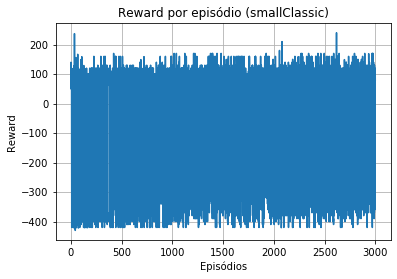

Reward máximo:  240 - Reward mínimo:  -430


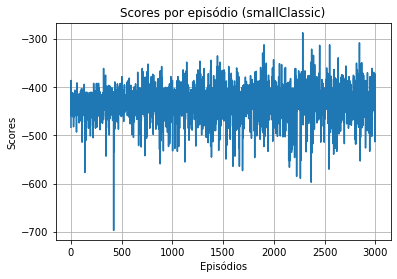

Score máximo:  -287.0 - Score mínimo:  -697.0


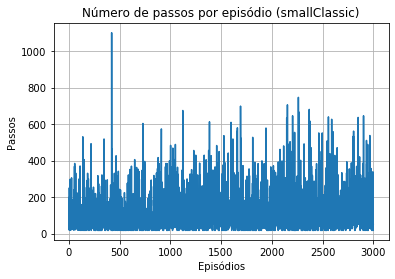

No passos máximo:  1101 - No passos mínimo:  18
Número de partidas ganhas:  0


In [12]:
seed = 489216598723
random.seed(seed)
input_str = "-l smallClassic -q"
args = readCommand(input_str.split())
agent = RLAgent_full()
args['pacman'] = agent
layout = args['layout']

# Inicialização do agente
agent.m = layout.width
agent.n = layout.height
agent.reward_list = []
agent.scores_list = []
agent.nsteps_list = []
agent.result_list = []

# Treinamento
n_episodes = 3000
for i in range(1,n_episodes+1):
    games = runGames(**args)
    agent.scores_list.append(games[0].state.getScore())
    agent.nsteps_list.append(len(games[0].moveHistory))
    agent.result_list.append(games[0].state.isWin())
    agent.reward_list.append(agent.episode_reward)
    agent.episode_reward = 0
    if agent.epsilon >= 0.001:
        agent.epsilon -= 0.001
        
RL_full_best_small = agent.qtable

# Impressão de estatísticas
print("Treinamento smallClassic com a primeira formulação (mapa completo)")
print("Número de episódios: ", n_episodes)
n_wins = 0
for jogada in agent.result_list:
    if jogada:
        n_wins += 1
print_episodes_graph(n_episodes, agent.reward_list, 'Reward', 'Reward por episódio (smallClassic)')
print("Reward máximo: ", max(agent.reward_list), "-", "Reward mínimo: ", min(agent.reward_list))
print_episodes_graph(n_episodes, agent.scores_list, 'Scores', 'Scores por episódio (smallClassic)')
print("Score máximo: ", max(agent.scores_list), "-", "Score mínimo: ", min(agent.scores_list))
print_episodes_graph(n_episodes, agent.nsteps_list, 'Passos', 'Número de passos por episódio (smallClassic)')
print("No passos máximo: ", max(agent.nsteps_list), "-", "No passos mínimo: ", min(agent.nsteps_list))
#print_episodes_graph(n_episodes, agent.result_list, 'Resultado', 'Resultado final por episódio (smallClassic)')
print("Número de partidas ganhas: ", n_wins)

##### $\rightarrow$ Segunda formulação: q-learning com estados definidos sobre o entorno do pacman

Treinamento smallClassic com a segunda formulação (entorno do pacman)
Número de episódios:  10000


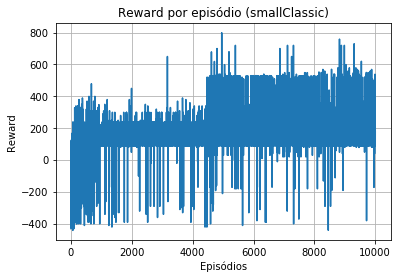

Reward máximo:  799 - Reward mínimo:  -441


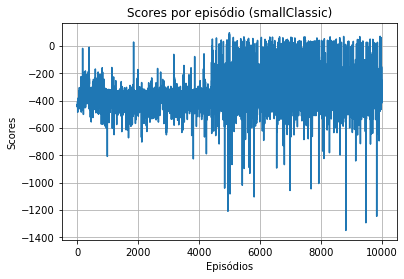

Score máximo:  96.0 - Score mínimo:  -1349.0


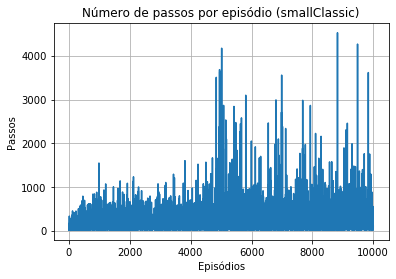

No passos máximo:  4527 - No passos mínimo:  16
Número de partidas ganhas:  0


In [13]:
seed = 7891259193
random.seed(seed)
input_str = "-l smallClassic -q"
args = readCommand(input_str.split())
agent1 = RLAgent_mini()
args['pacman'] = agent1
layout = args['layout']

# Incialização do agente
agent1.m = layout.width
agent1.n = layout.height
agent1.reward_list = []
agent1.scores_list = []
agent1.nsteps_list = []
agent1.result_list = []

# Treinamento
n_episodes = 10000
for i in range(1,n_episodes+1):
    games = runGames(**args)
    agent1.scores_list.append(games[0].state.getScore())
    agent1.nsteps_list.append(len(games[0].moveHistory))
    agent1.result_list.append(games[0].state.isWin())
    agent1.reward_list.append(agent1.episode_reward)
    agent1.episode_reward = 0
    if agent1.epsilon >= 0.001:
        agent1.epsilon -= 0.001
    
RL_mini_best_small = agent1.qtable

# Impressão de estatísticas
print("Treinamento smallClassic com a segunda formulação (entorno do pacman)")
print("Número de episódios: ", n_episodes)
n_wins = 0
for jogada in agent1.result_list:
    if jogada:
        n_wins += 1
print_episodes_graph(n_episodes, agent1.reward_list, 'Reward', 'Reward por episódio (smallClassic)')
print("Reward máximo: ", max(agent1.reward_list), "-", "Reward mínimo: ", min(agent1.reward_list))
print_episodes_graph(n_episodes, agent1.scores_list, 'Scores', 'Scores por episódio (smallClassic)')
print("Score máximo: ", max(agent1.scores_list), "-", "Score mínimo: ", min(agent1.scores_list))
print_episodes_graph(n_episodes, agent1.nsteps_list, 'Passos', 'Número de passos por episódio (smallClassic)')
print("No passos máximo: ", max(agent1.nsteps_list), "-", "No passos mínimo: ", min(agent1.nsteps_list))
print("Número de partidas ganhas: ", n_wins)

##### $\rightarrow$ Terceira formulação: q-learning com aproximador de função

Treinamento smallClassic com a terceira formulação (aproximador de função)
Número de episódios:  3000


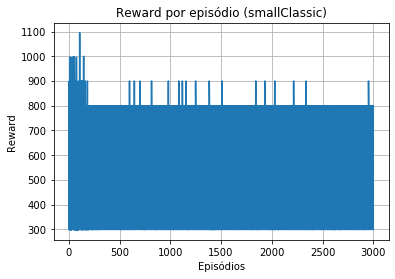

Reward máximo:  1095 - Reward mínimo:  296


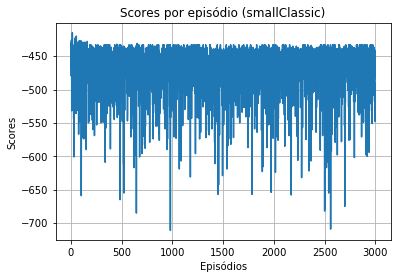

Score máximo:  -415.0 - Score mínimo:  -711.0


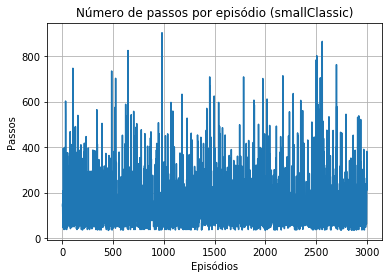

No passos máximo:  903 - No passos mínimo:  35
Número de partidas ganhas:  0


In [14]:
seed = 12540594
random.seed(seed)
input_str = "-l smallClassic -q"
args = readCommand(input_str.split())
agent_s = RL_AQ_Agent()
args['pacman'] = agent_s
layout = args['layout']

# Inicialização do agente
agent_s.m = layout.width
agent_s.n = layout.height
agent_s.total_food = layout.totalFood
agent_s.reward_list = []
agent_s.scores_list = []
agent_s.nsteps_list = []
agent_s.result_list = []

# Treinamento
n_episodes = 3000
for i in range(1,n_episodes+1):
    games = runGames(**args)
    agent_s.scores_list.append(games[0].state.getScore())
    agent_s.nsteps_list.append(len(games[0].moveHistory))
    agent_s.result_list.append(games[0].state.isWin())
    agent_s.reward_list.append(agent_s.episode_reward)
    agent_s.episode_reward = 0
    if agent_s.epsilon >= 0.001:
        agent_s.epsilon -= 0.001
        
RL_aprox_best_small = agent_s.qtable

# Impressão de estatísticas
print("Treinamento smallClassic com a terceira formulação (aproximador de função)")
print("Número de episódios: ", n_episodes)
n_wins = 0
for jogada in agent_s.result_list:
    if jogada:
        n_wins += 1
print_episodes_graph(n_episodes, agent_s.reward_list, 'Reward', 'Reward por episódio (smallClassic)')
print("Reward máximo: ", max(agent_s.reward_list), "-", "Reward mínimo: ", min(agent_s.reward_list))
print_episodes_graph(n_episodes, agent_s.scores_list, 'Scores', 'Scores por episódio (smallClassic)')
print("Score máximo: ", max(agent_s.scores_list), "-", "Score mínimo: ", min(agent_s.scores_list))
print_episodes_graph(n_episodes, agent_s.nsteps_list, 'Passos', 'Número de passos por episódio (smallClassic)')
print("No passos máximo: ", max(agent_s.nsteps_list), "-", "No passos mínimo: ", min(agent_s.nsteps_list))
print("Número de partidas ganhas: ", n_wins)

### 3.4.2 Mapa mediumClassic

Executamos as três formulações propostas, imprimindo o número de episódios considerado para o treinamento, gráficos de *reward* por episódio, *score* por episódio, número de passos por episódio e, finalmente, o número de partidas ganhas.

##### $\rightarrow$ Primeira formulação: q-learning com estados definidos sobre o mapa completo

Treinamento mediumClassic com a primeira formulação (mapa completo)
Número de episódios:  3000


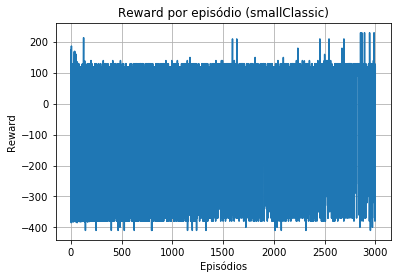

Reward máximo:  230 - Reward mínimo:  -410


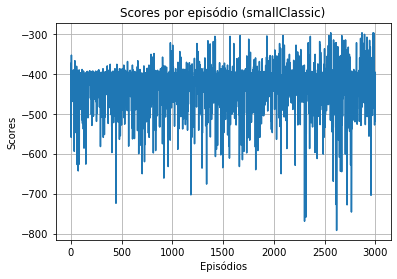

Score máximo:  -296.0 - Score mínimo:  -791.0


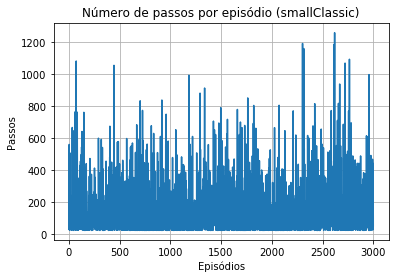

No passos máximo:  1261 - No passos mínimo:  24
Número de partidas ganhas:  0


In [15]:
seed = 489132164113
random.seed(seed)
input_str = "-l mediumClassic -q"
args = readCommand(input_str.split())
agent = RLAgent_full()
args['pacman'] = agent
layout = args['layout']

# Inicialização do agente
agent.m = layout.width
agent.n = layout.height
agent.reward_list = []
agent.scores_list = []
agent.nsteps_list = []
agent.result_list = []

# Treinamento
n_episodes = 3000
for i in range(1,n_episodes+1):
    games = runGames(**args)
    agent.scores_list.append(games[0].state.getScore())
    agent.nsteps_list.append(len(games[0].moveHistory))
    agent.result_list.append(games[0].state.isWin())
    agent.reward_list.append(agent.episode_reward)
    agent.episode_reward = 0
    if agent.epsilon >= 0.001:
        agent.epsilon -= 0.001
        
RL_full_best_medium = agent.qtable

# Impressão de estatísticas
print("Treinamento mediumClassic com a primeira formulação (mapa completo)")
print("Número de episódios: ", n_episodes)
n_wins = 0
for jogada in agent1.result_list:
    if jogada:
        n_wins += 1

print_episodes_graph(n_episodes, agent.reward_list, 'Reward', 'Reward por episódio (smallClassic)')
print("Reward máximo: ", max(agent.reward_list), "-", "Reward mínimo: ", min(agent.reward_list))
print_episodes_graph(n_episodes, agent.scores_list, 'Scores', 'Scores por episódio (smallClassic)')
print("Score máximo: ", max(agent.scores_list), "-", "Score mínimo: ", min(agent.scores_list))
print_episodes_graph(n_episodes, agent.nsteps_list, 'Passos', 'Número de passos por episódio (smallClassic)')
print("No passos máximo: ", max(agent.nsteps_list), "-", "No passos mínimo: ", min(agent.nsteps_list))
#print_episodes_graph(n_episodes, agent.result_list, 'Resultado', 'Resultado final por episódio (smallClassic)')
print("Número de partidas ganhas: ", n_wins)

##### $\rightarrow$ Segunda formulação: q-learning com estados definidos sobre o entorno do pacman

Treinamento mediumClassic com a segunda formulação (entorno do pacman)
Número de episódios:  10000


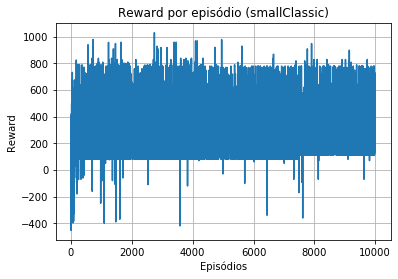

Reward máximo:  1030 - Reward mínimo:  -454


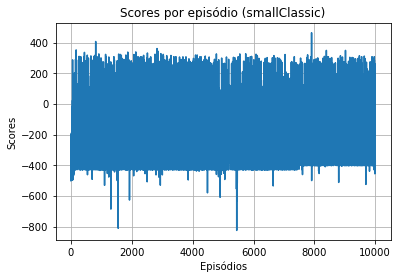

Score máximo:  464.0 - Score mínimo:  -825.0


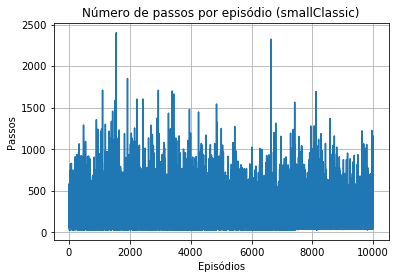

No passos máximo:  2402 - No passos mínimo:  23
Número de partidas ganhas:  0


In [18]:
seed = 5977139850
random.seed(seed)
input_str = "-l mediumClassic -q"
args = readCommand(input_str.split())
agent1 = RLAgent_mini()
args['pacman'] = agent1
layout = args['layout']

# Inicialização do agente
agent1.m = layout.width
agent1.n = layout.height
agent1.reward_list = []
agent1.scores_list = []
agent1.nsteps_list = []
agent1.result_list = []

# Treinamento
n_episodes = 10000
for i in range(1,n_episodes+1):
    games = runGames(**args)
    agent1.scores_list.append(games[0].state.getScore())
    agent1.nsteps_list.append(len(games[0].moveHistory))
    agent1.result_list.append(games[0].state.isWin())
    agent1.reward_list.append(agent1.episode_reward)
    agent1.episode_reward = 0
    if agent1.epsilon >= 0.001:
        agent1.epsilon -= 0.001

RL_mini_best_medium = agent1.qtable

# Impressão de estatísticas
print("Treinamento mediumClassic com a segunda formulação (entorno do pacman)")
print("Número de episódios: ", n_episodes)
n_wins = 0
for jogada in agent1.result_list:
    if jogada:
        n_wins += 1
print_episodes_graph(n_episodes, agent1.reward_list, 'Reward', 'Reward por episódio (smallClassic)')
print("Reward máximo: ", max(agent1.reward_list), "-", "Reward mínimo: ", min(agent1.reward_list))
print_episodes_graph(n_episodes, agent1.scores_list, 'Scores', 'Scores por episódio (smallClassic)')
print("Score máximo: ", max(agent1.scores_list), "-", "Score mínimo: ", min(agent1.scores_list))
print_episodes_graph(n_episodes, agent1.nsteps_list, 'Passos', 'Número de passos por episódio (smallClassic)')
print("No passos máximo: ", max(agent1.nsteps_list), "-", "No passos mínimo: ", min(agent1.nsteps_list))
#print_episodes_graph(n_episodes, agent.result_list, 'Resultado', 'Resultado final por episódio (smallClassic)')
print("Número de partidas ganhas: ", n_wins)

##### $\rightarrow$ Terceira formulação: q-learning com aproximador de função

Treinamento mediumClassic com a terceira formulação (aproximador de função)
Número de episódios:  3000


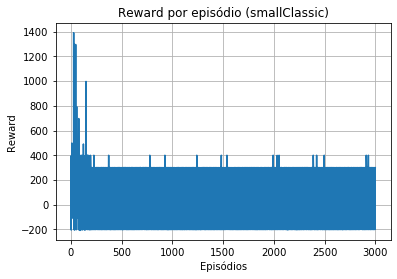

Reward máximo:  1391 - Reward mínimo:  -208


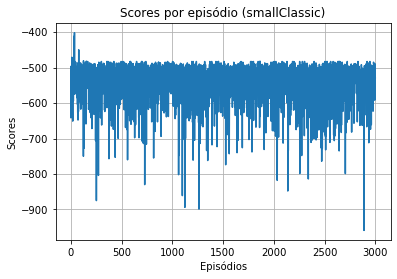

Score máximo:  -402.0 - Score mínimo:  -959.0


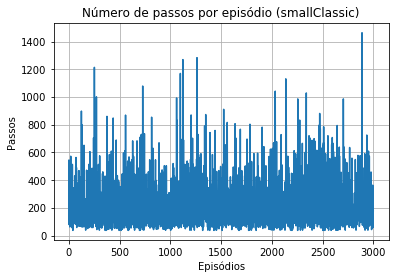

No passos máximo:  1465 - No passos mínimo:  37
Número de partidas ganhas:  0


In [17]:
seed = 7891216801502
random.seed(seed)
input_str = "-l mediumClassic -q"
args = readCommand(input_str.split())
agent_m = RL_AQ_Agent()
args['pacman'] = agent_m
layout = args['layout']

# Inicialização do agente
agent_m.m = layout.width
agent_m.n = layout.height
agent_m.total_food = layout.totalFood
agent_m.reward_list = []
agent_m.scores_list = []
agent_m.nsteps_list = []
agent_m.result_list = []

# Treinamento
n_episodes = 3000
for i in range(1,n_episodes+1):
    games = runGames(**args)
    agent_m.scores_list.append(games[0].state.getScore())
    agent_m.nsteps_list.append(len(games[0].moveHistory))
    agent_m.result_list.append(games[0].state.isWin())
    agent_m.reward_list.append(agent_m.episode_reward)
    agent_m.episode_reward = 0
    if agent_m.epsilon >= 0.001:
        agent_m.epsilon -= 0.001
        
RL_aprox_best_medium = agent_m.qtable

# Impressão de estatísticas
print("Treinamento mediumClassic com a terceira formulação (aproximador de função)")
print("Número de episódios: ", n_episodes)
n_wins = 0
for jogada in agent_m.result_list:
    if jogada:
        n_wins += 1
print_episodes_graph(n_episodes, agent_m.reward_list, 'Reward', 'Reward por episódio (smallClassic)')
print("Reward máximo: ", max(agent_m.reward_list), "-", "Reward mínimo: ", min(agent_m.reward_list))
print_episodes_graph(n_episodes, agent_m.scores_list, 'Scores', 'Scores por episódio (smallClassic)')
print("Score máximo: ", max(agent_m.scores_list), "-", "Score mínimo: ", min(agent_m.scores_list))
print_episodes_graph(n_episodes, agent_m.nsteps_list, 'Passos', 'Número de passos por episódio (smallClassic)')
print("No passos máximo: ", max(agent_m.nsteps_list), "-", "No passos mínimo: ", min(agent_m.nsteps_list))
print("Número de partidas ganhas: ", n_wins)

### 3.4.2 Mapa originalClassic

Executamos as três formulações propostas, imprimindo o número de episódios considerado para o treinamento, gráficos de *reward* por episódio, *score* por episódio, número de passos por episódio e, finalmente, o número de partidas ganhas.

##### $\rightarrow$ Primeira formulação: q-learning com estados definidos sobre o mapa completo

Treinamento mediumClassic com a primeira formulação (mapa completo)
Número de episódios:  1000


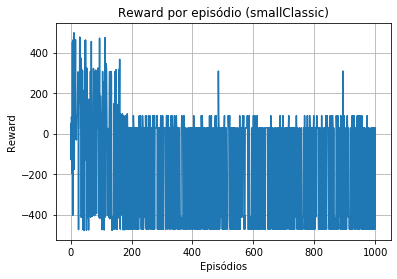

Reward máximo:  499 - Reward mínimo:  -476


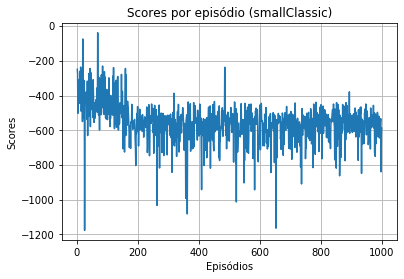

Score máximo:  -38.0 - Score mínimo:  -1178.0


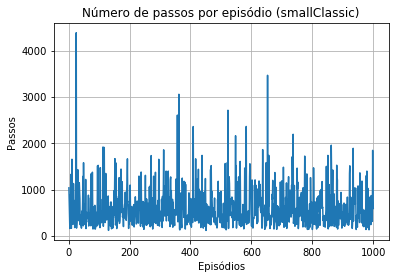

No passos máximo:  4390 - No passos mínimo:  121
Número de partidas ganhas:  0


In [19]:
seed = 498786512678
random.seed(seed)
input_str = "-l originalClassic -q"
args = readCommand(input_str.split())
agent = RLAgent_full()
args['pacman'] = agent
layout = args['layout']

# Inicialização do agente
agent.m = layout.width
agent.n = layout.height
agent.reward_list = []
agent.scores_list = []
agent.nsteps_list = []
agent.result_list = []

# Treinamento
n_episodes = 1000
for i in range(1,n_episodes+1):
    games = runGames(**args)
    agent.scores_list.append(games[0].state.getScore())
    agent.nsteps_list.append(len(games[0].moveHistory))
    agent.result_list.append(games[0].state.isWin())
    agent.reward_list.append(agent.episode_reward)
    agent.episode_reward = 0
    if agent.epsilon >= 0.001:
        agent.epsilon -= 0.001
        
RL_full_best_original = agent.qtable

# IMpressão de estatísticas
print("Treinamento originalClassic com a primeira formulação (mapa completo)")
print("Número de episódios: ", n_episodes)

n_wins = 0
for jogada in agent1.result_list:
    if jogada:
        n_wins += 1
print_episodes_graph(n_episodes, agent.reward_list, 'Reward', 'Reward por episódio (smallClassic)')
print("Reward máximo: ", max(agent.reward_list), "-", "Reward mínimo: ", min(agent.reward_list))
print_episodes_graph(n_episodes, agent.scores_list, 'Scores', 'Scores por episódio (smallClassic)')
print("Score máximo: ", max(agent.scores_list), "-", "Score mínimo: ", min(agent.scores_list))
print_episodes_graph(n_episodes, agent.nsteps_list, 'Passos', 'Número de passos por episódio (smallClassic)')
print("No passos máximo: ", max(agent.nsteps_list), "-", "No passos mínimo: ", min(agent.nsteps_list))
print("Número de partidas ganhas: ", n_wins)

##### $\rightarrow$ Segunda formulação: q-learning com estados definidos sobre o entorno do pacman

Treinamento originalClassic com a segunda formulação (entorno do pacman)
Número de episódios:  3000


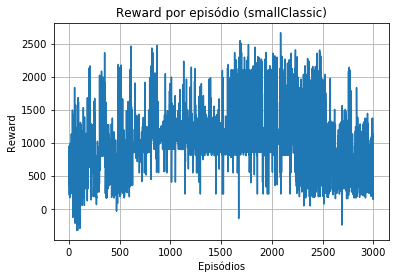

Reward máximo:  2670 - Reward mínimo:  -321


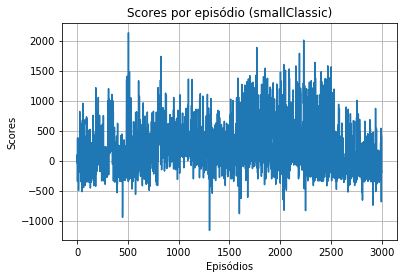

Score máximo:  2140.0 - Score mínimo:  -1156.0


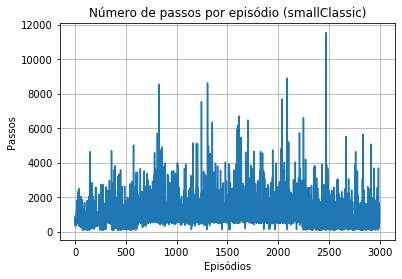

No passos máximo:  11538 - No passos mínimo:  79
Número de partidas ganhas:  0


In [25]:
seed = 789119994054
random.seed(seed)
input_str = "-l originalClassic -q"
args = readCommand(input_str.split())
agent1 = RLAgent_mini()
args['pacman'] = agent1
layout = args['layout']

# Inicialização do agente
agent1.m = layout.width
agent1.n = layout.height
agent1.reward_list = []
agent1.scores_list = []
agent1.nsteps_list = []
agent1.result_list = []

# Treinamento
n_episodes = 3000
for i in range(1,n_episodes+1):
    games = runGames(**args)
    agent1.scores_list.append(games[0].state.getScore())
    agent1.nsteps_list.append(len(games[0].moveHistory))
    agent1.result_list.append(games[0].state.isWin())
    agent1.reward_list.append(agent1.episode_reward)
    agent1.episode_reward = 0
    if agent1.epsilon >= 0.001:
        agent1.epsilon -= 0.001
        
RL_mini_best_original = agent1.qtable

# Impressão de estatísticas
print("Treinamento originalClassic com a segunda formulação (entorno do pacman)")
print("Número de episódios: ", n_episodes)

n_wins = 0
for jogada in agent1.result_list:
    if jogada:
        n_wins += 1
print_episodes_graph(n_episodes, agent1.reward_list, 'Reward', 'Reward por episódio (smallClassic)')
print("Reward máximo: ", max(agent1.reward_list), "-", "Reward mínimo: ", min(agent1.reward_list))
print_episodes_graph(n_episodes, agent1.scores_list, 'Scores', 'Scores por episódio (smallClassic)')
print("Score máximo: ", max(agent1.scores_list), "-", "Score mínimo: ", min(agent1.scores_list))
print_episodes_graph(n_episodes, agent1.nsteps_list, 'Passos', 'Número de passos por episódio (smallClassic)')
print("No passos máximo: ", max(agent1.nsteps_list), "-", "No passos mínimo: ", min(agent1.nsteps_list))
print("Número de partidas ganhas: ", n_wins)

##### $\rightarrow$ Terceira formulação: q-learning com aproximador de função

Treinamento originalClassic com a terceira formulação (aproximador de função)
Número de episódios:  500


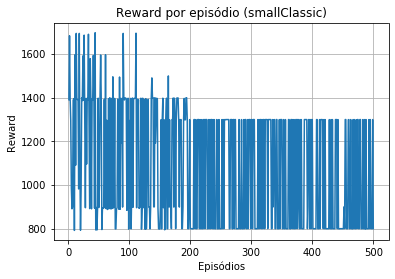

Reward máximo:  1698 - Reward mínimo:  792


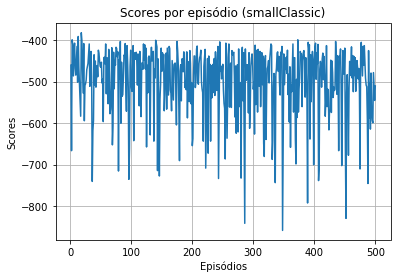

Score máximo:  -382.0 - Score mínimo:  -858.0


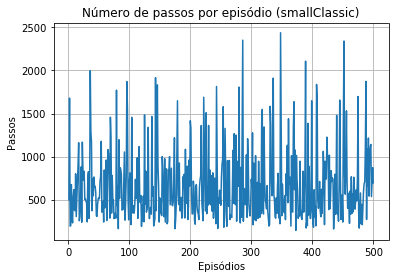

No passos máximo:  2437 - No passos mínimo:  144
Número de partidas ganhas:  0


In [24]:
seed = 484981238123
random.seed(seed)
input_str = "-l originalClassic -q"
args = readCommand(input_str.split())
agent = RL_AQ_Agent()
args['pacman'] = agent
layout = args['layout']

# Inicialização do agente
agent.m = layout.width
agent.n = layout.height
agent.total_food = layout.totalFood
agent.reward_list = []
agent.scores_list = []
agent.nsteps_list = []
agent.result_list = []

# Treinamento
n_episodes = 500
for i in range(1,n_episodes+1):
    games = runGames(**args)
    agent.scores_list.append(games[0].state.getScore())
    agent.nsteps_list.append(len(games[0].moveHistory))
    agent.result_list.append(games[0].state.isWin())
    agent.reward_list.append(agent.episode_reward)
    agent.episode_reward = 0
    if agent.epsilon >= 0.001:
        agent.epsilon -= 0.001
        
RL_aprox_best_original = agent.qtable

# Impressão de estatísticas
print("Treinamento originalClassic com a terceira formulação (aproximador de função)")
print("Número de episódios: ", n_episodes)

n_wins = 0
for jogada in agent.result_list:
    if jogada:
        n_wins += 1
print_episodes_graph(n_episodes, agent.reward_list, 'Reward', 'Reward por episódio (smallClassic)')
print("Reward máximo: ", max(agent.reward_list), "-", "Reward mínimo: ", min(agent.reward_list))
print_episodes_graph(n_episodes, agent.scores_list, 'Scores', 'Scores por episódio (smallClassic)')
print("Score máximo: ", max(agent.scores_list), "-", "Score mínimo: ", min(agent.scores_list))
print_episodes_graph(n_episodes, agent.nsteps_list, 'Passos', 'Número de passos por episódio (smallClassic)')
print("No passos máximo: ", max(agent.nsteps_list), "-", "No passos mínimo: ", min(agent.nsteps_list))
print("Número de partidas ganhas: ", n_wins)

## 3.5 Melhores Modelos 
Nesta seção, escolhemos o melhor modelo obtido após o treinamento para cada mapa e, em seguida, executamos dez rodadas do jogo utilizando tal modelo como referência na tomada de decisão do pacman.

Observe que, para os três mapas, em nenhuma das três formulações o treinamento convergiu para um nível de desempenho satisfatório. Nos três casos, não houve nenhuma vitória na fase de treinamento. Sendo assim, optamos por escolher como o melhor modelo aquele que produziu o maior *score* máximo. A seguir, apresentamos os melhores modelos de cada um dos mapas, bem como seu desempenho nas dez partidas jogadas.

##### $\rightarrow$ Melhor modelo para o mapa smallClassic
Para esse mapa, o melhor modelo foi o produzido pela segunda formulação, isto é, o uso do q-learning com os estados definidos sobre somente o entorno do pacman.

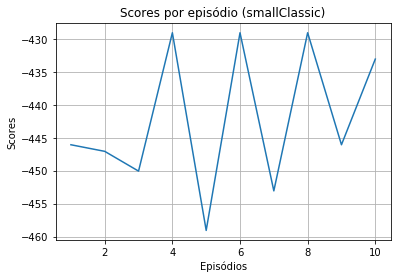

Score máximo:  -429.0 - Score mínimo:  -459.0
Número de partidas ganhas:  0


In [21]:
seed = 7986467
random.seed(seed)
input_str = "-l smallClassic -q"
args = readCommand(input_str.split())
player = RLplayer()
args['pacman'] = player
layout = args['layout']

player.m = layout.width
player.n = layout.height
player.qtable = RL_mini_best_small # seta a qtable para o melhor modelo

n_episodes = 10
for i in range(1,n_episodes+1):
    games = runGames(**args)
    player.scores_list.append(games[0].state.getScore())
    player.nsteps_list.append(len(games[0].moveHistory))
    player.result_list.append(games[0].state.isWin())
n_wins = 0
for jogada in player.result_list:
    if jogada:
        n_wins += 1
        
print_episodes_graph(n_episodes, player.scores_list, 'Scores', 'Scores por episódio (smallClassic)')
print("Score máximo: ", max(player.scores_list), "-", "Score mínimo: ", min(player.scores_list))
print("Número de partidas ganhas: ", n_wins)

##### $\rightarrow$ Melhor modelo para o mapa mediumClassic
Para esse mapa, o melhor modelo foi o produzido também pela segunda formulação, isto é, o uso do q-learning com os estados definidos sobre somente o entorno do pacman.

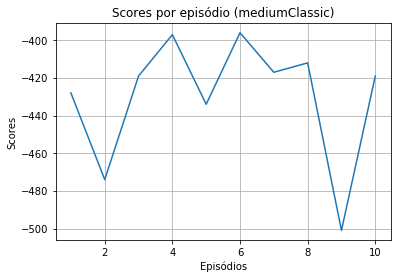

Score máximo:  -396.0 - Score mínimo:  -501.0
Número de partidas ganhas:  0


In [23]:
seed = 7986467
random.seed(seed)
input_str = "-l mediumClassic -q"
args = readCommand(input_str.split())
player = RLplayer()
args['pacman'] = player
layout = args['layout']

player.m = layout.width
player.n = layout.height
player.qtable = RL_mini_best_medium # seta a qtable para o melhor modelo
player.scores_list = []
player.nsteps_list = []
player.result_list = []

n_episodes = 10
for i in range(1,n_episodes+1):
    games = runGames(**args)
    player.scores_list.append(games[0].state.getScore())
    player.nsteps_list.append(len(games[0].moveHistory))
    player.result_list.append(games[0].state.isWin())
n_wins = 0
for jogada in player.result_list:
    if jogada:
        n_wins += 1
        
print_episodes_graph(n_episodes, player.scores_list, 'Scores', 'Scores por episódio (mediumClassic)')
print("Score máximo: ", max(player.scores_list), "-", "Score mínimo: ", min(player.scores_list))
print("Número de partidas ganhas: ", n_wins)

##### $\rightarrow$ Melhor modelo para o mapa originalClassic
Para esse mapa, o melhor modelo foi o produzido pela segunda formulação, isto é, o uso do q-learning com os estados definidos sobre somente o entorno do pacman.

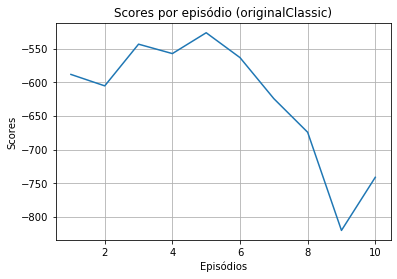

Score máximo:  -526.0 - Score mínimo:  -820.0
Número de partidas ganhas:  0


In [27]:
seed = 12816904
random.seed(seed)
input_str = "-l originalClassic -q"
args = readCommand(input_str.split())
player = RLplayer()
args['pacman'] = player
layout = args['layout']

player.m = layout.width
player.n = layout.height
player.scores_list = []
player.nsteps_list = []
player.result_list = []
player.qtable = RL_mini_best_original # seta a qtable para o melhor modelo

n_episodes = 10
for i in range(1,n_episodes+1):
    games = runGames(**args)
    player.scores_list.append(games[0].state.getScore())
    player.nsteps_list.append(len(games[0].moveHistory))
    player.result_list.append(games[0].state.isWin())
n_wins = 0
for jogada in player.result_list:
    if jogada:
        n_wins += 1
        
print_episodes_graph(n_episodes, player.scores_list, 'Scores', 'Scores por episódio (originalClassic)')
print("Score máximo: ", max(player.scores_list), "-", "Score mínimo: ", min(player.scores_list))
print("Número de partidas ganhas: ", n_wins)

## 3.6 Conclusões

Os experimentos realizados revelam que as formulações definidas não foram adequadas.
Na primeira formulação, tentamos uma abordagem que veio naturalmente em mente. Pensamos que, por ter todas as informações do mapa, o treinamento eventualmente iria convergir para um modelo razoável. No entanto, logo percebemos que essa abordagem não é escalável. Apesar disso, tentamos executar o treinamento também nos mapas maiores, mesmo utilizando um número menor de episódios para treinar. No entanto, não obtivemos bons resultados para nenhum dos mapas, nem mesmo no menor deles.

A partir dessa primeira ideia, pensamos em reduzir o espaço de estados e, por isso, tentamos a abordagem de considerar somente o entorno da posição corrente do pacman. Além de diminuir o número total de estados distintos, pensamos que essa formulação seria melhor pois, o mesmo estado poderia ocorrer em diferentes partes do mapa. Pensamos que esse fator melhoraria o desempenho do treinamento, mas os experimentos mostram que não houve melhora significativa, quando houve. A principal vantagem dessa abordagem é o tamanho reduzido do espaço de estados, possibilitando um aumento no número de episódios utilizados para o treinamento.

Como ambas abordagens anteriores não deram certo, tentamos aplicar outra estratégia, agregando o uso de aproximação de função ao algoritmo q-learning. Nesse caso, foi preciso definir funções que relacionam um estado e uma ação, que são chamadas de *features*. O espaço de ações foi o mesmo que o utilizado nas formulações anteriores. Contudo, novamente não obtivemos sucesso no treinamento. Julgamos que o principal fator que pode ter influenciado no mal desempenho do algoritmo foi o conjunto de *features*, que pode não ter sido adequado para que o treinamento convergisse.

Dentre as três formulações propostas, a que conseguiu atingir *scores* mais altos foi a segunda, isto é, o q-learning com estados definido somente sobre o entorno do pacman. Uma desvantagem desse modelo, que pudemos notar ao executar o *framework* com interface gráfica, é que o pacman fica muito tempo na mesma região do mapa e não consegue explorá-lo inteiramente. Acreditamos que parte desse comportamento seja consequência de ter definido estados sobre um contexto bastante local.

# 4 Comparação entre modelos

Devido ao fato de nenhuma das abordagens empregadas no aprendizado por reforço ter convergido, ficamos sem base de comparação detalha entre os dois métodos. O que pode-se observar, assim, é que os modelos evolucionários obtiveram resultados muito bons, enquanto os modelos por aprendizado por reforço obtiveram resultados muito ruins. Contudo, isso não nos dá embasamento para comparar as duas técnicas.

# 5 Considerações Finais

Neste *notebook*, apresentamos as definições dos problemas explorados, os métodos utilizados para resolvê-los, assim como os resultados obtidos, de acordo com a especificação do projeto. Em particular, destacamos os seguintes pontos que foram exibidos no relatório.

Na Seção 1, apresentamos o jogo do Pacman e definimos o Problema do Pacman.

Na Seção 2, resolvemos o Problema do Pacman por meio de um algoritmo evolucionário baseado em Programação Genética:
* Nas Seções 2.1 e 2.2, introduzimos os principais conceitos relativos a Algoritmos Genéticos e Programação Genética. Nas Seções 2.2.1 a 2.2.3 descrevemos detalhadamente o nosso algoritmo de Programação Genética, incluindo as estrututas de dados utilizadas, a função de *fitness*, as estratégias adotadas nas etapas de seleção, *crossover*, mutação e substituição de população, etc.
* Na Seção 2.3, temos o código-fonte relativo à parte $I$ do trabalho.
* Na Seção 2.4, conduzimos experimentos com o algoritmo desenvolvido e discutimos os resultados. Em particular, descrevemos as parametrizações adotadas para os três *layouts* utilizados. Também computamos métricas de avaliação em relações às gerações produzidas nas execuções do algoritmo, tais como *fitness* e pontuação (mínima, máxima e média), e número de movimentos dos agentes (média). Utilizamos tais métricas para avaliar a qualidade das soluções produzidas.

Portanto, cumprimos todas as tarefas previstas na especificação do projeto relativa à Parte $I$.

Na Seção 3, abordamos o Problema do Pacman por meio de um algoritmo de aprendizado por reforço.

* Nas seções 3.1 e 3.2, apresentamos as formulações adotadas, bem como os algoritmos utilizados.
* Na Seção 3.3, temos o código-fonte referente à parte $II$ do trabalho.
* Na Seção 3.4, apresentamos os experimentos realizados com cada um dos três mapas e, na Seção 3.5, mostramos o melhor modelo obtido para cada um dos mapas, bem como seu desempenho ao jogar dez partidas do jogo.
* Na Seção 3.6, fazemos observações sobre as abordagens adotadas, o desempenho das formulações e seus problemas.
 
Assim, cumprimos todas as tarefas previstas na especificação do projeto relativa à Parte $II$.

Além disso, na Seção 4, comparamos e discutimos o desempenho dos melhores modelos obtidos na Parte $I$ e Parte $II$ para cada um dos *layouts*.

Ambos discentes participaram ativamente durante todo o projeto. O aluno Felipe foi responsável pela realização da Parte $I$ do projeto, enquanto a aluna Elisa foi responsável pela realização da Parte $II$. As pesquisas, revisões de código-fonte e tomadas de decisão foram feitas em conjunto. 

# 6 Referências Bibliográficas

[1] ALPAYDIN, E. Introduction to Machine Learning. MIT Press, 3rd edition, 2014.

[2] BISHOP, C. M. Pattern Recognition and Machine Learning. Springer. Cambridge, 2007.

[3] MARSLAND, S. Machine Learning: an algorithm perspective. CRC Press, 2nd edition, 2015.

[4] BRANDSTETTER, Matthias F.; AHMADI, Samad. Reactive control of Ms. Pac Man using information retrieval based on genetic programming. In: 2012 IEEE Conference on Computational Intelligence and Games (CIG). IEEE, 2012. p. 250-256.

[5] ALHEJALI, Atif M.; LUCAS, Simon M. Evolving diverse Ms. Pac-Man playing agents using genetic programming. In: 2010 UK Workshop on Computational Intelligence (UKCI). IEEE, 2010. p. 1-6.

[6] GNANASEKARAN, Abeynaya; FABA, Jordi Feliu; AN, Jing. Reinforcement Learning in Pacman., 2017.

[7] The Pac-Man Projects. Disponível em https://cs.brynmawr.edu/Courses/cs372/fall2017/ (acesso em junho de 2021).

[8] MEO, Roland. Deep Q-Learning With Features Exemplified By Pacman. Hamburg University of Applied Sciences. 